HW1 solution
======

## Behavioural cloning


#### 22.06.2019 (alex)

<p>So currently we are working on improving our behavioural cloning model and in the meanwhile learn how to build better neural nets. The bottleneck of the project is that we can't still run roboschool gym on the cloud, so for now trainers **can not use roboschool library**, this means that dataset must be generated locally and then uploaded on the cloud.</p>
<br>
<ul>To be done
    <li>[x] Run notebook and check that everything work</li>
    <li>[] How to run roboschool </li>
    <li>[ ] Implement validation set and put validation score as output2 of train_and_save</li>
    <li>[IN PROGRESS ] After having checked that scores make sense try to improve model, some ideas: add regularization like dropout layers</li></ul>



In [1]:
import pickle as pk

In [2]:
import os
DATA_FOLDER_2 = ("../../gcloud_data")
DATA_FOLDER_1 = ("../../../gcloud_data")
# https://storage.googleapis.com/relna-mlengine/data/RoboschoolHumanoid-v1-small.pkl
try:
    expert_rollouts = pk.load(open(os.path.join(DATA_FOLDER_2, "RoboschoolHumanoid-v1-small.pkl"),"rb"))
except FileNotFoundError:
    print("not found (1)")
    pass
try:
    expert_rollouts = pk.load(open(os.path.join(DATA_FOLDER_2, "RoboschoolHumanoid-v1.pkl"),"rb"))
except FileNotFoundError:
    print("not found (2)")
    pass
try:
    expert_rollouts = pk.load(open(os.path.join(DATA_FOLDER_1, "RoboschoolHumanoid-v1-small.pkl"),"rb"))
except FileNotFoundError:
    print("not found (1)")
    pass
try:
    expert_rollouts = pk.load(open(os.path.join(DATA_FOLDER_1, "RoboschoolHumanoid-v1.pkl"),"rb"))
except FileNotFoundError:
    print("not found (2)")
    pass

try:
    assert(expert_rollouts)
    print("success")
except:
    print("###### (relna) MISSING DATA\nThe data to run this model is not there, to get the data run the following command from /relna-client\n\
    (venv) python relna.py --command data\nto download the data of the trainer you forked\n######")

not found (1)
not found (2)
not found (1)
success


In [3]:
expert_rollouts['observations'].shape

(18147, 44)

In [4]:
expert_rollouts['actions'].shape

(18147, 17)

In [5]:
expert_rollouts['returns'].shape

(20,)

In [6]:
expert_rollouts['returns']

array([ -54.27031156, 3248.04912194, 3263.61761704, 3197.71683768,
       3231.50132934, 3245.74853189, 3233.24997896, 3252.12301659,
       3241.4273884 , 3235.21184583, 3257.9256866 , 3203.19485249,
       3208.41443098, 3221.29153921, 3267.0523209 ,   97.17868354,
       3238.48170587, 3190.6505161 , 3190.35004848, 3201.92343234])

In [7]:
inputs = expert_rollouts['observations']
outputs = expert_rollouts['actions']

In [8]:
assert len(inputs) == len(outputs)

In [9]:
split = int(len(inputs)*0.8)
print(split)

14517


In [10]:
X_train, y_train = inputs[:split], outputs[:split]
X_validation, y_validation = inputs[split:], outputs[split:]

model
========

In [11]:
INPUT_SIZE = 44
OUTPUT_SIZE = 17

In [12]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print(local_device_protos)
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [13]:
get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18001269597245997642
]


[]

In [14]:
#! pip install tensorflow

In [15]:
#import tensorflow as tf

In [16]:
#from tensorflow.python.pywrap_tensorflow_internal import *

In [17]:
import tensorflow as tf
import numpy as np
# (alex) you may need to pip install this since they are not in the requirement of relna
# if you want to do this professionally you can deactivate relna-client virtualenv and create a new one
# with anaconda in case you are having problem, don't forget to reactivate relna-client when you want to ship

In [18]:
def tf_reset():
    try:
        sess.close()
    except:
        pass
    tf.reset_default_graph()
    return tf.Session()

In [19]:
sess = tf_reset()
def create_model():
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, INPUT_SIZE]) # [None, 1] is because is 1D array
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, OUTPUT_SIZE])
    dropout_hidden_layer_probability = tf.placeholder(dtype=tf.float32)
    
    W0 = tf.get_variable(name='W0', shape=[INPUT_SIZE, 100], initializer = tf.contrib.layers.variance_scaling_initializer())
    W1 = tf.get_variable(name='W1', shape=[100, 200], initializer = tf.contrib.layers.variance_scaling_initializer())
    W2 = tf.get_variable(name='W2', shape=[200, 100], initializer = tf.contrib.layers.variance_scaling_initializer())
    W3 = tf.get_variable(name='W3', shape=[100, 60], initializer = tf.contrib.layers.variance_scaling_initializer())
    W4 = tf.get_variable(name='W4', shape=[60, 30], initializer = tf.contrib.layers.variance_scaling_initializer())
    W5 = tf.get_variable(name='W5', shape=[30, OUTPUT_SIZE], initializer = tf.contrib.layers.variance_scaling_initializer())
    
    
    b0 = tf.get_variable(name='b0', shape=[100], initializer = tf.constant_initializer(0))
    b1 = tf.get_variable(name='b1', shape=[200], initializer = tf.constant_initializer(0))
    b2 = tf.get_variable(name='b2', shape=[100], initializer = tf.constant_initializer(0))
    b3 = tf.get_variable(name='b3', shape=[60], initializer = tf.constant_initializer(0))
    b4 = tf.get_variable(name='b4', shape=[30], initializer = tf.constant_initializer(0))
    b5 = tf.get_variable(name='b5', shape=[OUTPUT_SIZE], initializer = tf.constant_initializer(0))
    
    weights = [W0, W1, W2, W3, W4, W5]
    biases = [b0, b1, b2, b3, b4, b5]
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, tf.nn.relu, tf.nn.relu, None]
    dropouts = [None, tf.nn.dropout, tf.nn.dropout, None, None, None]
    
    layer = input_ph
    for W, b, activation, dropout in zip(weights, biases, activations, dropouts):
        layer = tf.matmul(layer, W) + b
        if activation is not None:
            layer = activation(layer)
        if dropout is not None:
            layer = tf.nn.dropout(layer, rate=dropout_hidden_layer_probability)
            
    output_pred = layer
    return input_ph, output_ph, output_pred, dropout_hidden_layer_probability

In [20]:
input_ph, output_ph, output_pred, dropout_hidden_layer_probability = create_model()

mse = tf.reduce_mean(0.5 * tf.square(output_pred - output_ph)) # this is the mean square error
opt = tf.train.AdamOptimizer().minimize(mse) # this is an operation that pereform gradient descent

sess.run(tf.global_variables_initializer())
saver = tf.train.Saver() # save weight as the training goes on

W0711 13:07:56.345180 140735711744960 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [21]:
#training

#hyperparameters

batch_size = 32
# probability for which a node is discarded
dropout_input_layer_probability_train = 0.2
dropout_hidden_layer_probability_train = 0
dropout_input_layer_probability_validation = 0
dropout_hidden_layer_probability_validation = 0

# training session

training_mse = []
validation_mse = []
for training_step in range(30000):
    #random batch
    indices = np.random.randint(low = 0, high = len(X_train), size = batch_size)
    input_batch = X_train[indices]
    output_batch = y_train[indices]
    
    # run optimizer and get mse
    _, mse_run = sess.run([opt, mse], feed_dict={
        input_ph: input_batch, 
        output_ph: output_batch,
        dropout_hidden_layer_probability: dropout_hidden_layer_probability_train,
    })
    
    training_mse.append(mse_run)
    
    #random validation batch
    indices_validation = np.random.randint(low = 0, high = len(X_validation), size = batch_size)
    input_batch_validation = X_validation[indices_validation]
    output_batch_validation = y_validation[indices_validation]
    
    assert (input_batch_validation != input_batch).any()
    # get mse validation
    mse_validation = sess.run(mse, feed_dict={input_ph: input_batch_validation, output_ph: output_batch_validation, dropout_hidden_layer_probability: dropout_hidden_layer_probability_validation})

    validation_mse.append(mse_validation)

    if training_step % 1000 == 0:
        
        print('epochs = {0:04d}, mse training = {1:.3f}, mse validation = {2:.3f}'.format(
            training_step, mse_run, mse_validation))
        saver.save(sess, '/tmp/model.ckpt')

epochs = 0000, mse training = 0.296, mse validation = 0.204
epochs = 1000, mse training = 0.019, mse validation = 0.021
epochs = 2000, mse training = 0.012, mse validation = 0.016
epochs = 3000, mse training = 0.011, mse validation = 0.009
epochs = 4000, mse training = 0.007, mse validation = 0.016
epochs = 5000, mse training = 0.010, mse validation = 0.013
epochs = 6000, mse training = 0.008, mse validation = 0.008
epochs = 7000, mse training = 0.008, mse validation = 0.010
epochs = 8000, mse training = 0.007, mse validation = 0.006
epochs = 9000, mse training = 0.006, mse validation = 0.011
epochs = 10000, mse training = 0.007, mse validation = 0.004
epochs = 11000, mse training = 0.005, mse validation = 0.008
epochs = 12000, mse training = 0.005, mse validation = 0.010
epochs = 13000, mse training = 0.006, mse validation = 0.009
epochs = 14000, mse training = 0.005, mse validation = 0.004
epochs = 15000, mse training = 0.006, mse validation = 0.011
epochs = 16000, mse training = 0.0

In [22]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(training_mse, color='b', label='training')

#indexes_validation = list(range(0, 15000, 1000))
plt.plot(validation_mse, color='r', alpha=0.5, label='validation')

plt.legend()
#run two times if it doesn't show

In [23]:
sess = tf_reset()

input_ph, output_ph, output_pred, dropout_hidden_layer_probability = create_model()
saver = tf.train.Saver() 
saver.restore(sess, "/tmp/model.ckpt")

W0711 13:09:03.691509 140735711744960 deprecation.py:323] From /Users/alex/Desktop/Coding/AI/relna-client/venv/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [24]:
# prediction of only one action
output_pred_run = sess.run(output_pred, feed_dict={
    input_ph: X_validation[0].reshape((1,INPUT_SIZE)),
    dropout_hidden_layer_probability: 0 })

In [25]:
output_pred_run

array([[-0.6254412 ,  0.37412074,  0.11495391, -0.27735838,  1.2559705 ,
         0.430181  ,  1.2811921 , -0.03899034,  0.6473509 , -0.46636572,
         0.2938081 ,  1.1462187 ,  0.30851153, -0.45451587,  0.36436984,
        -0.02313004, -0.83019054]], dtype=float32)

In [26]:
y_validation[0]

array([-0.67215571,  0.51215087,  0.16319634, -0.30910832,  1.15198657,
        0.38291435,  1.11849179, -0.04375689,  0.68908028, -0.61239793,
        0.25298019,  1.2005717 ,  0.26903097, -0.57398159,  0.43115737,
        0.01838841, -0.88039469])

In [27]:
mse = ((output_pred_run[0] - y_validation[0])**2).mean(axis=None)

In [28]:
mse # this is the current output_1

0.006843196627900232

# IMITATION LEARNING
this part is to actually make run the robot and requires roboschool, so none of the following code can be run on the cloud

In [29]:
import gym, roboschool

In [30]:
#!pip install gym

In [31]:
#!pip install roboschool

In [32]:
env=gym.make("RoboschoolHumanoid-v1")

In [33]:
env

<TimeLimit<RoboschoolHumanoid<RoboschoolHumanoid-v1>>>

In [34]:
import os;os.listdir('.')

['.ipynb_checkpoints',
 '__init__.py',
 '__pycache__',
 'BehaviouralCloning-RoboschoolHumanoid.ipynb',
 'GCSproxy.py',
 'model.py',
 'run_expert.py',
 'task.py',
 'tf_util.py',
 'Untitled.ipynb',
 'utils.py']

In [35]:
import run_expert

In [36]:
class Policy():
    def __init__(self):
        self.sess = tf_reset()

        self.input_ph, self.output_ph, self.output_pred, self.dropout_hidden_layer_probability = create_model()
        saver = tf.train.Saver() 
        saver.restore(self.sess, "/tmp/model.ckpt")
        
    def act(self, obs):
        return self.sess.run(self.output_pred, feed_dict={
            self.input_ph: obs.reshape((1,INPUT_SIZE)),
            self.dropout_hidden_layer_probability: 0})[0]

In [37]:
policy=Policy()

In [38]:
roboschool_results = run_expert.run_policy(env,policy,100,"running trained model",render=True,max_timesteps=100000)
# here the mean return is the end goal of this task, the best I got is 60

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50
iter 51
iter 52
iter 53
iter 54
iter 55
iter 56
iter 57
iter 58
iter 59
iter 60
iter 61
iter 62
iter 63
iter 64
iter 65
iter 66
iter 67
iter 68
iter 69
100/100000
iter 70
iter 71
iter 72
iter 73
100/100000
iter 74
iter 75
iter 76
iter 77
iter 78
iter 79
iter 80
iter 81
iter 82
iter 83
100/100000
iter 84
iter 85
iter 86
iter 87
iter 88
iter 89
iter 90
iter 91
iter 92
iter 93
iter 94
iter 95
iter 96
iter 97
iter 98
iter 99
Env description: running trained model
mean return 65.98718811979823
std of return 38.564333407786606


In [39]:
def get_results_statistics(roboschool_results):
    return roboschool_results['returns'].mean(), roboschool_results['returns'].std(), roboschool_results['returns'].max(), roboschool_results['returns'].min()
get_results_statistics(roboschool_results)

(65.98718811979823,
 38.564333407786606,
 268.98597446932104,
 -42.017818215010635)

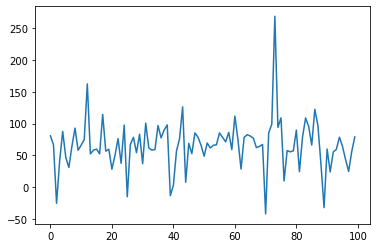

In [40]:
plt.plot(roboschool_results['returns'])

### DAGGER

In [41]:
# example of usage of expert policy

dagger_results = [(roboschool_results['returns'].mean(), roboschool_results['returns'].std())]

dagger_results

import importlib
def get_expert_policy(envname='RoboschoolHumanoid-v1', EXPERT_DIR='experts'):
    ROBOSCOOL_AVAILABLE_ENVS = ['RoboschoolAnt-v1', 'RoboschoolHumanoid-v1', 'RoboschoolHalfCheetah-v1', 'RoboschoolReacher-v1',
                     'RoboschoolHopper-v1', 'RoboschoolWalker2d-v1']
    assert envname in ROBOSCOOL_AVAILABLE_ENVS
    # Load the policy module
    module_name = "%s.%s" % (EXPERT_DIR, envname)
    policy_module = importlib.import_module(module_name)
    env, policy = policy_module.get_env_and_policy()
    return policy


import sys
sys.path.append('/Users/alex/Desktop/Coding/AI/CS294_DeepReinforcementLearning/homeworks/hw1')

policy = get_expert_policy()

policy.act

policy.act(roboschool_results['observations'][0])

array([-0.0444244 ,  0.30706472,  0.34023873,  0.64966315,  0.17425565,
        0.9320493 ,  0.42907995,  0.49927715,  0.1983765 ,  0.41162975,
        0.26485269,  0.58002698,  0.30520973,  0.00333043, -0.43032625,
       -0.03528868, -0.48882099])

In [42]:
observations = roboschool_results['observations']
expert_actions = np.asarray([policy.act(obs) for obs in observations])

In [43]:
roboschool_results['actions'].shape == expert_actions.shape

True

### DAGGER LOOP

In [44]:
def aggregate_dataset(old_dataset, new_observations, new_expert_actions):
    new_dataset = {
        'observations': np.concatenate([old_dataset['observations'], new_observations]),
        'actions': np.concatenate([old_dataset['actions'], new_expert_actions])
    }
    return new_dataset   

In [46]:
def run_dagger_iteration(dataset):
    
    ## DATA MANIPULATION 
    
    print(dataset['observations'].shape, dataset['actions'].shape)

    inputs = dataset['observations']
    outputs = dataset['actions']

    assert len(inputs) == len(outputs)

    split = int(len(inputs)*0.8)
    print(split)

    X_train, y_train = inputs[:split], outputs[:split]
    X_validation, y_validation = inputs[split:], outputs[split:]
    
    ## TRAIN TENSORFLOW MODEL
    
    sess = tf_reset()
    input_ph, output_ph, output_pred, dropout_hidden_layer_probability = create_model()

    mse = tf.reduce_mean(0.5 * tf.square(output_pred - output_ph)) # this is the mean square error
    opt = tf.train.AdamOptimizer().minimize(mse) # this is an operation that pereform gradient descent

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver() # save weight as the training goes on
    
    #training

    #hyperparameters

    batch_size = 32
    # probability for which a node is discarded
    dropout_input_layer_probability_train = 0.2
    dropout_hidden_layer_probability_train = 0
    dropout_input_layer_probability_validation = 0
    dropout_hidden_layer_probability_validation = 0

    # training session

    training_mse = []
    validation_mse = []
    for training_step in range(40000):
        #random batch
        indices = np.random.randint(low = 0, high = len(X_train), size = batch_size)
        input_batch = X_train[indices]
        output_batch = y_train[indices]

        # run optimizer and get mse
        _, mse_run = sess.run([opt, mse], feed_dict={
            input_ph: input_batch, 
            output_ph: output_batch,
            dropout_hidden_layer_probability: dropout_hidden_layer_probability_train,
        })

        training_mse.append(mse_run)

        #random validation batch
        indices_validation = np.random.randint(low = 0, high = len(X_validation), size = batch_size)
        input_batch_validation = X_validation[indices_validation]
        output_batch_validation = y_validation[indices_validation]

        assert (input_batch_validation != input_batch).any()
        # get mse validation
        mse_validation = sess.run(mse, feed_dict={input_ph: input_batch_validation, output_ph: output_batch_validation, dropout_hidden_layer_probability: dropout_hidden_layer_probability_validation})

        validation_mse.append(mse_validation)

        if training_step % 1000 == 0:

            print('epochs = {0:04d}, mse training = {1:.3f}, mse validation = {2:.3f}'.format(
                training_step, mse_run, mse_validation))
            saver.save(sess, '/tmp/model.ckpt')
            
    ## RUN LEARNED POLICY

    policy=Policy() # learned policy
    roboschool_results = run_expert.run_policy(env,policy,200,"running trained model",render=False,max_timesteps=100000)


    ## RUN EXPERT POLICY ON OBSERVATIONS

    policy = get_expert_policy() #expert policy
    observations = roboschool_results['observations']
    expert_actions = np.asarray([policy.act(obs) for obs in observations])

    new_dataset = aggregate_dataset(dataset, observations, expert_actions)    

    return new_dataset, roboschool_results

In [48]:
dagger_iters = range(100)
dagger_results = [(get_results_statistics(roboschool_results))]
dataset =  aggregate_dataset(expert_rollouts, roboschool_results['observations'], roboschool_results['actions'])

for dagger_iter in dagger_iters:
    dataset, results = run_dagger_iteration(dataset)
    print("######## DAGGER {} #######".format(dagger_iter))
    print(results)
    dagger_results.append((get_results_statistics(results)))

(24515, 44) (24515, 17)
19612
epochs = 0000, mse training = 0.234, mse validation = 0.203
epochs = 1000, mse training = 0.027, mse validation = 0.045
epochs = 2000, mse training = 0.010, mse validation = 0.048
epochs = 3000, mse training = 0.016, mse validation = 0.052
epochs = 4000, mse training = 0.011, mse validation = 0.045
epochs = 5000, mse training = 0.012, mse validation = 0.044
epochs = 6000, mse training = 0.008, mse validation = 0.041
epochs = 7000, mse training = 0.009, mse validation = 0.038
epochs = 8000, mse training = 0.008, mse validation = 0.022
epochs = 9000, mse training = 0.009, mse validation = 0.029
epochs = 10000, mse training = 0.006, mse validation = 0.030
epochs = 11000, mse training = 0.007, mse validation = 0.042
epochs = 12000, mse training = 0.008, mse validation = 0.038
epochs = 13000, mse training = 0.008, mse validation = 0.039
epochs = 14000, mse training = 0.007, mse validation = 0.029
epochs = 15000, mse training = 0.006, mse validation = 0.036
epoc

epochs = 0000, mse training = 0.308, mse validation = 0.354
epochs = 1000, mse training = 0.031, mse validation = 0.138
epochs = 2000, mse training = 0.021, mse validation = 0.081
epochs = 3000, mse training = 0.021, mse validation = 0.080
epochs = 4000, mse training = 0.019, mse validation = 0.074
epochs = 5000, mse training = 0.020, mse validation = 0.084
epochs = 6000, mse training = 0.015, mse validation = 0.063
epochs = 7000, mse training = 0.012, mse validation = 0.056
epochs = 8000, mse training = 0.019, mse validation = 0.066
epochs = 9000, mse training = 0.011, mse validation = 0.061
epochs = 10000, mse training = 0.016, mse validation = 0.064
epochs = 11000, mse training = 0.015, mse validation = 0.059
epochs = 12000, mse training = 0.013, mse validation = 0.065
epochs = 13000, mse training = 0.013, mse validation = 0.044
epochs = 14000, mse training = 0.011, mse validation = 0.069
epochs = 15000, mse training = 0.011, mse validation = 0.103
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.541, mse validation = 0.463
epochs = 1000, mse training = 0.049, mse validation = 0.095
epochs = 2000, mse training = 0.050, mse validation = 0.081
epochs = 3000, mse training = 0.038, mse validation = 0.060
epochs = 4000, mse training = 0.029, mse validation = 0.053
epochs = 5000, mse training = 0.027, mse validation = 0.073
epochs = 6000, mse training = 0.019, mse validation = 0.057
epochs = 7000, mse training = 0.024, mse validation = 0.069
epochs = 8000, mse training = 0.022, mse validation = 0.036
epochs = 9000, mse training = 0.016, mse validation = 0.057
epochs = 10000, mse training = 0.016, mse validation = 0.039
epochs = 11000, mse training = 0.017, mse validation = 0.043
epochs = 12000, mse training = 0.025, mse validation = 0.053
epochs = 13000, mse training = 0.014, mse validation = 0.037
epochs = 14000, mse training = 0.017, mse validation = 0.044
epochs = 15000, mse training = 0.017, mse validation = 0.058
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.340, mse validation = 0.421
epochs = 1000, mse training = 0.051, mse validation = 0.131
epochs = 2000, mse training = 0.049, mse validation = 0.109
epochs = 3000, mse training = 0.031, mse validation = 0.127
epochs = 4000, mse training = 0.032, mse validation = 0.089
epochs = 5000, mse training = 0.025, mse validation = 0.096
epochs = 6000, mse training = 0.034, mse validation = 0.111
epochs = 7000, mse training = 0.035, mse validation = 0.108
epochs = 8000, mse training = 0.023, mse validation = 0.064
epochs = 9000, mse training = 0.030, mse validation = 0.105
epochs = 10000, mse training = 0.019, mse validation = 0.098
epochs = 11000, mse training = 0.026, mse validation = 0.110
epochs = 12000, mse training = 0.024, mse validation = 0.121
epochs = 13000, mse training = 0.021, mse validation = 0.105
epochs = 14000, mse training = 0.025, mse validation = 0.090
epochs = 15000, mse training = 0.025, mse validation = 0.091
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.546, mse validation = 0.563
epochs = 1000, mse training = 0.069, mse validation = 0.080
epochs = 2000, mse training = 0.037, mse validation = 0.067
epochs = 3000, mse training = 0.028, mse validation = 0.069
epochs = 4000, mse training = 0.033, mse validation = 0.094
epochs = 5000, mse training = 0.037, mse validation = 0.055
epochs = 6000, mse training = 0.028, mse validation = 0.048
epochs = 7000, mse training = 0.022, mse validation = 0.060
epochs = 8000, mse training = 0.029, mse validation = 0.056
epochs = 9000, mse training = 0.022, mse validation = 0.055
epochs = 10000, mse training = 0.028, mse validation = 0.058
epochs = 11000, mse training = 0.027, mse validation = 0.053
epochs = 12000, mse training = 0.025, mse validation = 0.051
epochs = 13000, mse training = 0.029, mse validation = 0.037
epochs = 14000, mse training = 0.022, mse validation = 0.065
epochs = 15000, mse training = 0.021, mse validation = 0.052
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.804, mse validation = 0.478
epochs = 1000, mse training = 0.066, mse validation = 0.073
epochs = 2000, mse training = 0.069, mse validation = 0.063
epochs = 3000, mse training = 0.042, mse validation = 0.062
epochs = 4000, mse training = 0.054, mse validation = 0.044
epochs = 5000, mse training = 0.029, mse validation = 0.033
epochs = 6000, mse training = 0.050, mse validation = 0.067
epochs = 7000, mse training = 0.038, mse validation = 0.044
epochs = 8000, mse training = 0.025, mse validation = 0.045
epochs = 9000, mse training = 0.026, mse validation = 0.047
epochs = 10000, mse training = 0.026, mse validation = 0.033
epochs = 11000, mse training = 0.031, mse validation = 0.034
epochs = 12000, mse training = 0.033, mse validation = 0.042
epochs = 13000, mse training = 0.025, mse validation = 0.049
epochs = 14000, mse training = 0.025, mse validation = 0.039
epochs = 15000, mse training = 0.022, mse validation = 0.042
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.665, mse validation = 0.498
epochs = 1000, mse training = 0.071, mse validation = 0.062
epochs = 2000, mse training = 0.054, mse validation = 0.092
epochs = 3000, mse training = 0.044, mse validation = 0.066
epochs = 4000, mse training = 0.035, mse validation = 0.063
epochs = 5000, mse training = 0.031, mse validation = 0.047
epochs = 6000, mse training = 0.038, mse validation = 0.055
epochs = 7000, mse training = 0.035, mse validation = 0.040
epochs = 8000, mse training = 0.032, mse validation = 0.060
epochs = 9000, mse training = 0.037, mse validation = 0.055
epochs = 10000, mse training = 0.025, mse validation = 0.054
epochs = 11000, mse training = 0.035, mse validation = 0.037
epochs = 12000, mse training = 0.025, mse validation = 0.046
epochs = 13000, mse training = 0.025, mse validation = 0.052
epochs = 14000, mse training = 0.024, mse validation = 0.070
epochs = 15000, mse training = 0.019, mse validation = 0.063
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.476, mse validation = 0.385
epochs = 1000, mse training = 0.052, mse validation = 0.091
epochs = 2000, mse training = 0.052, mse validation = 0.071
epochs = 3000, mse training = 0.040, mse validation = 0.053
epochs = 4000, mse training = 0.049, mse validation = 0.056
epochs = 5000, mse training = 0.033, mse validation = 0.048
epochs = 6000, mse training = 0.021, mse validation = 0.049
epochs = 7000, mse training = 0.031, mse validation = 0.047
epochs = 8000, mse training = 0.028, mse validation = 0.052
epochs = 9000, mse training = 0.020, mse validation = 0.036
epochs = 10000, mse training = 0.031, mse validation = 0.043
epochs = 11000, mse training = 0.027, mse validation = 0.043
epochs = 12000, mse training = 0.033, mse validation = 0.046
epochs = 13000, mse training = 0.022, mse validation = 0.039
epochs = 14000, mse training = 0.024, mse validation = 0.035
epochs = 15000, mse training = 0.025, mse validation = 0.036
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.519, mse validation = 0.499
epochs = 1000, mse training = 0.053, mse validation = 0.097
epochs = 2000, mse training = 0.030, mse validation = 0.060
epochs = 3000, mse training = 0.038, mse validation = 0.051
epochs = 4000, mse training = 0.036, mse validation = 0.060
epochs = 5000, mse training = 0.033, mse validation = 0.057
epochs = 6000, mse training = 0.025, mse validation = 0.067
epochs = 7000, mse training = 0.040, mse validation = 0.052
epochs = 8000, mse training = 0.031, mse validation = 0.046
epochs = 9000, mse training = 0.032, mse validation = 0.045
epochs = 10000, mse training = 0.028, mse validation = 0.043
epochs = 11000, mse training = 0.039, mse validation = 0.037
epochs = 12000, mse training = 0.034, mse validation = 0.058
epochs = 13000, mse training = 0.030, mse validation = 0.055
epochs = 14000, mse training = 0.020, mse validation = 0.034
epochs = 15000, mse training = 0.025, mse validation = 0.064
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.480, mse validation = 0.333
epochs = 1000, mse training = 0.073, mse validation = 0.083
epochs = 2000, mse training = 0.040, mse validation = 0.063
epochs = 3000, mse training = 0.066, mse validation = 0.066
epochs = 4000, mse training = 0.033, mse validation = 0.077
epochs = 5000, mse training = 0.044, mse validation = 0.075
epochs = 6000, mse training = 0.031, mse validation = 0.054
epochs = 7000, mse training = 0.042, mse validation = 0.046
epochs = 8000, mse training = 0.032, mse validation = 0.039
epochs = 9000, mse training = 0.034, mse validation = 0.059
epochs = 10000, mse training = 0.050, mse validation = 0.045
epochs = 11000, mse training = 0.024, mse validation = 0.035
epochs = 12000, mse training = 0.030, mse validation = 0.079
epochs = 13000, mse training = 0.041, mse validation = 0.048
epochs = 14000, mse training = 0.032, mse validation = 0.063
epochs = 15000, mse training = 0.020, mse validation = 0.033
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.374, mse validation = 0.366
epochs = 1000, mse training = 0.059, mse validation = 0.115
epochs = 2000, mse training = 0.062, mse validation = 0.072
epochs = 3000, mse training = 0.049, mse validation = 0.055
epochs = 4000, mse training = 0.044, mse validation = 0.069
epochs = 5000, mse training = 0.037, mse validation = 0.038
epochs = 6000, mse training = 0.037, mse validation = 0.057
epochs = 7000, mse training = 0.036, mse validation = 0.063
epochs = 8000, mse training = 0.035, mse validation = 0.048
epochs = 9000, mse training = 0.031, mse validation = 0.050
epochs = 10000, mse training = 0.026, mse validation = 0.040
epochs = 11000, mse training = 0.029, mse validation = 0.058
epochs = 12000, mse training = 0.025, mse validation = 0.039
epochs = 13000, mse training = 0.028, mse validation = 0.047
epochs = 14000, mse training = 0.026, mse validation = 0.041
epochs = 15000, mse training = 0.020, mse validation = 0.045
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.318, mse validation = 0.454
epochs = 1000, mse training = 0.053, mse validation = 0.069
epochs = 2000, mse training = 0.046, mse validation = 0.043
epochs = 3000, mse training = 0.035, mse validation = 0.047
epochs = 4000, mse training = 0.056, mse validation = 0.063
epochs = 5000, mse training = 0.038, mse validation = 0.033
epochs = 6000, mse training = 0.026, mse validation = 0.036
epochs = 7000, mse training = 0.042, mse validation = 0.047
epochs = 8000, mse training = 0.035, mse validation = 0.048
epochs = 9000, mse training = 0.038, mse validation = 0.035
epochs = 10000, mse training = 0.032, mse validation = 0.059
epochs = 11000, mse training = 0.025, mse validation = 0.029
epochs = 12000, mse training = 0.026, mse validation = 0.030
epochs = 13000, mse training = 0.026, mse validation = 0.037
epochs = 14000, mse training = 0.035, mse validation = 0.040
epochs = 15000, mse training = 0.024, mse validation = 0.030
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.666, mse validation = 0.467
epochs = 1000, mse training = 0.059, mse validation = 0.072
epochs = 2000, mse training = 0.057, mse validation = 0.045
epochs = 3000, mse training = 0.058, mse validation = 0.068
epochs = 4000, mse training = 0.036, mse validation = 0.044
epochs = 5000, mse training = 0.036, mse validation = 0.061
epochs = 6000, mse training = 0.040, mse validation = 0.038
epochs = 7000, mse training = 0.028, mse validation = 0.033
epochs = 8000, mse training = 0.030, mse validation = 0.053
epochs = 9000, mse training = 0.032, mse validation = 0.033
epochs = 10000, mse training = 0.035, mse validation = 0.040
epochs = 11000, mse training = 0.032, mse validation = 0.024
epochs = 12000, mse training = 0.032, mse validation = 0.028
epochs = 13000, mse training = 0.032, mse validation = 0.035
epochs = 14000, mse training = 0.026, mse validation = 0.032
epochs = 15000, mse training = 0.018, mse validation = 0.040
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.464, mse validation = 0.361
epochs = 1000, mse training = 0.069, mse validation = 0.061
epochs = 2000, mse training = 0.068, mse validation = 0.037
epochs = 3000, mse training = 0.051, mse validation = 0.044
epochs = 4000, mse training = 0.032, mse validation = 0.036
epochs = 5000, mse training = 0.044, mse validation = 0.032
epochs = 6000, mse training = 0.034, mse validation = 0.032
epochs = 7000, mse training = 0.032, mse validation = 0.049
epochs = 8000, mse training = 0.029, mse validation = 0.024
epochs = 9000, mse training = 0.031, mse validation = 0.029
epochs = 10000, mse training = 0.032, mse validation = 0.029
epochs = 11000, mse training = 0.037, mse validation = 0.035
epochs = 12000, mse training = 0.029, mse validation = 0.036
epochs = 13000, mse training = 0.034, mse validation = 0.033
epochs = 14000, mse training = 0.025, mse validation = 0.029
epochs = 15000, mse training = 0.029, mse validation = 0.033
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.403, mse validation = 0.216
epochs = 1000, mse training = 0.071, mse validation = 0.062
epochs = 2000, mse training = 0.065, mse validation = 0.069
epochs = 3000, mse training = 0.047, mse validation = 0.057
epochs = 4000, mse training = 0.035, mse validation = 0.051
epochs = 5000, mse training = 0.038, mse validation = 0.047
epochs = 6000, mse training = 0.032, mse validation = 0.047
epochs = 7000, mse training = 0.045, mse validation = 0.039
epochs = 8000, mse training = 0.034, mse validation = 0.034
epochs = 9000, mse training = 0.032, mse validation = 0.039
epochs = 10000, mse training = 0.037, mse validation = 0.046
epochs = 11000, mse training = 0.026, mse validation = 0.036
epochs = 12000, mse training = 0.029, mse validation = 0.040
epochs = 13000, mse training = 0.030, mse validation = 0.035
epochs = 14000, mse training = 0.032, mse validation = 0.023
epochs = 15000, mse training = 0.034, mse validation = 0.038
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.733, mse validation = 0.471
epochs = 1000, mse training = 0.074, mse validation = 0.059
epochs = 2000, mse training = 0.044, mse validation = 0.047
epochs = 3000, mse training = 0.037, mse validation = 0.042
epochs = 4000, mse training = 0.038, mse validation = 0.056
epochs = 5000, mse training = 0.039, mse validation = 0.040
epochs = 6000, mse training = 0.032, mse validation = 0.028
epochs = 7000, mse training = 0.038, mse validation = 0.034
epochs = 8000, mse training = 0.032, mse validation = 0.035
epochs = 9000, mse training = 0.041, mse validation = 0.026
epochs = 10000, mse training = 0.032, mse validation = 0.027
epochs = 11000, mse training = 0.020, mse validation = 0.026
epochs = 12000, mse training = 0.034, mse validation = 0.035
epochs = 13000, mse training = 0.027, mse validation = 0.027
epochs = 14000, mse training = 0.023, mse validation = 0.025
epochs = 15000, mse training = 0.026, mse validation = 0.030
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.932, mse validation = 0.588
epochs = 1000, mse training = 0.070, mse validation = 0.054
epochs = 2000, mse training = 0.065, mse validation = 0.058
epochs = 3000, mse training = 0.056, mse validation = 0.048
epochs = 4000, mse training = 0.038, mse validation = 0.050
epochs = 5000, mse training = 0.038, mse validation = 0.029
epochs = 6000, mse training = 0.034, mse validation = 0.034
epochs = 7000, mse training = 0.035, mse validation = 0.033
epochs = 8000, mse training = 0.044, mse validation = 0.039
epochs = 9000, mse training = 0.041, mse validation = 0.050
epochs = 10000, mse training = 0.026, mse validation = 0.035
epochs = 11000, mse training = 0.043, mse validation = 0.030
epochs = 12000, mse training = 0.040, mse validation = 0.022
epochs = 13000, mse training = 0.028, mse validation = 0.026
epochs = 14000, mse training = 0.025, mse validation = 0.033
epochs = 15000, mse training = 0.032, mse validation = 0.030
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.956, mse validation = 0.597
epochs = 1000, mse training = 0.044, mse validation = 0.071
epochs = 2000, mse training = 0.062, mse validation = 0.072
epochs = 3000, mse training = 0.032, mse validation = 0.038
epochs = 4000, mse training = 0.048, mse validation = 0.036
epochs = 5000, mse training = 0.049, mse validation = 0.032
epochs = 6000, mse training = 0.042, mse validation = 0.039
epochs = 7000, mse training = 0.039, mse validation = 0.029
epochs = 8000, mse training = 0.025, mse validation = 0.031
epochs = 9000, mse training = 0.028, mse validation = 0.037
epochs = 10000, mse training = 0.024, mse validation = 0.034
epochs = 11000, mse training = 0.032, mse validation = 0.022
epochs = 12000, mse training = 0.038, mse validation = 0.026
epochs = 13000, mse training = 0.025, mse validation = 0.040
epochs = 14000, mse training = 0.017, mse validation = 0.026
epochs = 15000, mse training = 0.023, mse validation = 0.028
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.503, mse validation = 0.459
epochs = 1000, mse training = 0.057, mse validation = 0.057
epochs = 2000, mse training = 0.048, mse validation = 0.060
epochs = 3000, mse training = 0.049, mse validation = 0.048
epochs = 4000, mse training = 0.059, mse validation = 0.047
epochs = 5000, mse training = 0.031, mse validation = 0.037
epochs = 6000, mse training = 0.036, mse validation = 0.030
epochs = 7000, mse training = 0.030, mse validation = 0.035
epochs = 8000, mse training = 0.027, mse validation = 0.029
epochs = 9000, mse training = 0.032, mse validation = 0.036
epochs = 10000, mse training = 0.018, mse validation = 0.029
epochs = 11000, mse training = 0.027, mse validation = 0.032
epochs = 12000, mse training = 0.027, mse validation = 0.027
epochs = 13000, mse training = 0.029, mse validation = 0.026
epochs = 14000, mse training = 0.025, mse validation = 0.033
epochs = 15000, mse training = 0.020, mse validation = 0.023
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.444, mse validation = 0.390
epochs = 1000, mse training = 0.056, mse validation = 0.043
epochs = 2000, mse training = 0.049, mse validation = 0.035
epochs = 3000, mse training = 0.044, mse validation = 0.038
epochs = 4000, mse training = 0.049, mse validation = 0.035
epochs = 5000, mse training = 0.036, mse validation = 0.034
epochs = 6000, mse training = 0.035, mse validation = 0.034
epochs = 7000, mse training = 0.033, mse validation = 0.032
epochs = 8000, mse training = 0.026, mse validation = 0.033
epochs = 9000, mse training = 0.023, mse validation = 0.030
epochs = 10000, mse training = 0.030, mse validation = 0.033
epochs = 11000, mse training = 0.036, mse validation = 0.030
epochs = 12000, mse training = 0.032, mse validation = 0.039
epochs = 13000, mse training = 0.028, mse validation = 0.036
epochs = 14000, mse training = 0.037, mse validation = 0.024
epochs = 15000, mse training = 0.023, mse validation = 0.027
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.615, mse validation = 0.462
epochs = 1000, mse training = 0.077, mse validation = 0.062
epochs = 2000, mse training = 0.057, mse validation = 0.047
epochs = 3000, mse training = 0.051, mse validation = 0.047
epochs = 4000, mse training = 0.048, mse validation = 0.037
epochs = 5000, mse training = 0.056, mse validation = 0.033
epochs = 6000, mse training = 0.037, mse validation = 0.033
epochs = 7000, mse training = 0.032, mse validation = 0.041
epochs = 8000, mse training = 0.041, mse validation = 0.031
epochs = 9000, mse training = 0.038, mse validation = 0.030
epochs = 10000, mse training = 0.038, mse validation = 0.045
epochs = 11000, mse training = 0.035, mse validation = 0.033
epochs = 12000, mse training = 0.027, mse validation = 0.034
epochs = 13000, mse training = 0.028, mse validation = 0.034
epochs = 14000, mse training = 0.047, mse validation = 0.028
epochs = 15000, mse training = 0.030, mse validation = 0.026
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.981, mse validation = 0.665
epochs = 1000, mse training = 0.065, mse validation = 0.056
epochs = 2000, mse training = 0.042, mse validation = 0.049
epochs = 3000, mse training = 0.050, mse validation = 0.056
epochs = 4000, mse training = 0.032, mse validation = 0.030
epochs = 5000, mse training = 0.029, mse validation = 0.045
epochs = 6000, mse training = 0.029, mse validation = 0.042
epochs = 7000, mse training = 0.042, mse validation = 0.029
epochs = 8000, mse training = 0.036, mse validation = 0.032
epochs = 9000, mse training = 0.037, mse validation = 0.033
epochs = 10000, mse training = 0.029, mse validation = 0.029
epochs = 11000, mse training = 0.027, mse validation = 0.034
epochs = 12000, mse training = 0.027, mse validation = 0.028
epochs = 13000, mse training = 0.029, mse validation = 0.029
epochs = 14000, mse training = 0.031, mse validation = 0.029
epochs = 15000, mse training = 0.022, mse validation = 0.027
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 1.295, mse validation = 0.646
epochs = 1000, mse training = 0.094, mse validation = 0.066
epochs = 2000, mse training = 0.044, mse validation = 0.038
epochs = 3000, mse training = 0.049, mse validation = 0.039
epochs = 4000, mse training = 0.041, mse validation = 0.036
epochs = 5000, mse training = 0.036, mse validation = 0.054
epochs = 6000, mse training = 0.039, mse validation = 0.032
epochs = 7000, mse training = 0.030, mse validation = 0.028
epochs = 8000, mse training = 0.035, mse validation = 0.022
epochs = 9000, mse training = 0.039, mse validation = 0.037
epochs = 10000, mse training = 0.027, mse validation = 0.033
epochs = 11000, mse training = 0.034, mse validation = 0.027
epochs = 12000, mse training = 0.027, mse validation = 0.021
epochs = 13000, mse training = 0.028, mse validation = 0.028
epochs = 14000, mse training = 0.025, mse validation = 0.032
epochs = 15000, mse training = 0.040, mse validation = 0.037
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.498, mse validation = 0.402
epochs = 1000, mse training = 0.057, mse validation = 0.074
epochs = 2000, mse training = 0.042, mse validation = 0.057
epochs = 3000, mse training = 0.034, mse validation = 0.043
epochs = 4000, mse training = 0.034, mse validation = 0.045
epochs = 5000, mse training = 0.044, mse validation = 0.039
epochs = 6000, mse training = 0.030, mse validation = 0.046
epochs = 7000, mse training = 0.032, mse validation = 0.036
epochs = 8000, mse training = 0.026, mse validation = 0.034
epochs = 9000, mse training = 0.027, mse validation = 0.030
epochs = 10000, mse training = 0.030, mse validation = 0.030
epochs = 11000, mse training = 0.025, mse validation = 0.036
epochs = 12000, mse training = 0.043, mse validation = 0.028
epochs = 13000, mse training = 0.028, mse validation = 0.029
epochs = 14000, mse training = 0.027, mse validation = 0.036
epochs = 15000, mse training = 0.034, mse validation = 0.029
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.656, mse validation = 0.412
epochs = 1000, mse training = 0.072, mse validation = 0.065
epochs = 2000, mse training = 0.088, mse validation = 0.049
epochs = 3000, mse training = 0.046, mse validation = 0.042
epochs = 4000, mse training = 0.050, mse validation = 0.041
epochs = 5000, mse training = 0.041, mse validation = 0.028
epochs = 6000, mse training = 0.035, mse validation = 0.035
epochs = 7000, mse training = 0.034, mse validation = 0.040
epochs = 8000, mse training = 0.047, mse validation = 0.033
epochs = 9000, mse training = 0.032, mse validation = 0.028
epochs = 10000, mse training = 0.028, mse validation = 0.033
epochs = 11000, mse training = 0.035, mse validation = 0.033
epochs = 12000, mse training = 0.031, mse validation = 0.026
epochs = 13000, mse training = 0.022, mse validation = 0.031
epochs = 14000, mse training = 0.020, mse validation = 0.028
epochs = 15000, mse training = 0.024, mse validation = 0.030
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.565, mse validation = 0.379
epochs = 1000, mse training = 0.065, mse validation = 0.053
epochs = 2000, mse training = 0.045, mse validation = 0.056
epochs = 3000, mse training = 0.042, mse validation = 0.039
epochs = 4000, mse training = 0.036, mse validation = 0.036
epochs = 5000, mse training = 0.033, mse validation = 0.039
epochs = 6000, mse training = 0.033, mse validation = 0.031
epochs = 7000, mse training = 0.028, mse validation = 0.053
epochs = 8000, mse training = 0.039, mse validation = 0.038
epochs = 9000, mse training = 0.023, mse validation = 0.036
epochs = 10000, mse training = 0.039, mse validation = 0.032
epochs = 11000, mse training = 0.029, mse validation = 0.030
epochs = 12000, mse training = 0.021, mse validation = 0.032
epochs = 13000, mse training = 0.036, mse validation = 0.040
epochs = 14000, mse training = 0.033, mse validation = 0.027
epochs = 15000, mse training = 0.032, mse validation = 0.033
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.500, mse validation = 0.426
epochs = 1000, mse training = 0.075, mse validation = 0.058
epochs = 2000, mse training = 0.041, mse validation = 0.048
epochs = 3000, mse training = 0.054, mse validation = 0.041
epochs = 4000, mse training = 0.037, mse validation = 0.047
epochs = 5000, mse training = 0.031, mse validation = 0.045
epochs = 6000, mse training = 0.024, mse validation = 0.029
epochs = 7000, mse training = 0.038, mse validation = 0.030
epochs = 8000, mse training = 0.029, mse validation = 0.035
epochs = 9000, mse training = 0.030, mse validation = 0.037
epochs = 10000, mse training = 0.021, mse validation = 0.032
epochs = 11000, mse training = 0.031, mse validation = 0.030
epochs = 12000, mse training = 0.026, mse validation = 0.045
epochs = 13000, mse training = 0.037, mse validation = 0.029
epochs = 14000, mse training = 0.035, mse validation = 0.039
epochs = 15000, mse training = 0.033, mse validation = 0.024
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.651, mse validation = 0.519
epochs = 1000, mse training = 0.061, mse validation = 0.059
epochs = 2000, mse training = 0.054, mse validation = 0.058
epochs = 3000, mse training = 0.038, mse validation = 0.036
epochs = 4000, mse training = 0.040, mse validation = 0.043
epochs = 5000, mse training = 0.035, mse validation = 0.046
epochs = 6000, mse training = 0.038, mse validation = 0.029
epochs = 7000, mse training = 0.035, mse validation = 0.042
epochs = 8000, mse training = 0.041, mse validation = 0.039
epochs = 9000, mse training = 0.027, mse validation = 0.029
epochs = 10000, mse training = 0.036, mse validation = 0.030
epochs = 11000, mse training = 0.039, mse validation = 0.025
epochs = 12000, mse training = 0.033, mse validation = 0.023
epochs = 13000, mse training = 0.035, mse validation = 0.026
epochs = 14000, mse training = 0.036, mse validation = 0.038
epochs = 15000, mse training = 0.035, mse validation = 0.023
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.637, mse validation = 0.445
epochs = 1000, mse training = 0.077, mse validation = 0.085
epochs = 2000, mse training = 0.048, mse validation = 0.053
epochs = 3000, mse training = 0.042, mse validation = 0.044
epochs = 4000, mse training = 0.042, mse validation = 0.047
epochs = 5000, mse training = 0.030, mse validation = 0.037
epochs = 6000, mse training = 0.043, mse validation = 0.031
epochs = 7000, mse training = 0.036, mse validation = 0.029
epochs = 8000, mse training = 0.048, mse validation = 0.039
epochs = 9000, mse training = 0.023, mse validation = 0.041
epochs = 10000, mse training = 0.033, mse validation = 0.023
epochs = 11000, mse training = 0.030, mse validation = 0.025
epochs = 12000, mse training = 0.024, mse validation = 0.025
epochs = 13000, mse training = 0.035, mse validation = 0.036
epochs = 14000, mse training = 0.026, mse validation = 0.042
epochs = 15000, mse training = 0.023, mse validation = 0.023
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.832, mse validation = 0.527
epochs = 1000, mse training = 0.061, mse validation = 0.063
epochs = 2000, mse training = 0.057, mse validation = 0.061
epochs = 3000, mse training = 0.034, mse validation = 0.034
epochs = 4000, mse training = 0.043, mse validation = 0.031
epochs = 5000, mse training = 0.042, mse validation = 0.046
epochs = 6000, mse training = 0.041, mse validation = 0.034
epochs = 7000, mse training = 0.030, mse validation = 0.032
epochs = 8000, mse training = 0.035, mse validation = 0.031
epochs = 9000, mse training = 0.034, mse validation = 0.031
epochs = 10000, mse training = 0.028, mse validation = 0.028
epochs = 11000, mse training = 0.028, mse validation = 0.032
epochs = 12000, mse training = 0.025, mse validation = 0.030
epochs = 13000, mse training = 0.023, mse validation = 0.028
epochs = 14000, mse training = 0.030, mse validation = 0.028
epochs = 15000, mse training = 0.026, mse validation = 0.022
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.493, mse validation = 0.393
epochs = 1000, mse training = 0.059, mse validation = 0.065
epochs = 2000, mse training = 0.073, mse validation = 0.059
epochs = 3000, mse training = 0.057, mse validation = 0.038
epochs = 4000, mse training = 0.041, mse validation = 0.042
epochs = 5000, mse training = 0.037, mse validation = 0.031
epochs = 6000, mse training = 0.039, mse validation = 0.034
epochs = 7000, mse training = 0.032, mse validation = 0.035
epochs = 8000, mse training = 0.030, mse validation = 0.039
epochs = 9000, mse training = 0.035, mse validation = 0.026
epochs = 10000, mse training = 0.038, mse validation = 0.030
epochs = 11000, mse training = 0.029, mse validation = 0.025
epochs = 12000, mse training = 0.030, mse validation = 0.023
epochs = 13000, mse training = 0.034, mse validation = 0.036
epochs = 14000, mse training = 0.034, mse validation = 0.028
epochs = 15000, mse training = 0.026, mse validation = 0.028
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.822, mse validation = 0.517
epochs = 1000, mse training = 0.089, mse validation = 0.063
epochs = 2000, mse training = 0.058, mse validation = 0.048
epochs = 3000, mse training = 0.046, mse validation = 0.053
epochs = 4000, mse training = 0.040, mse validation = 0.037
epochs = 5000, mse training = 0.027, mse validation = 0.037
epochs = 6000, mse training = 0.031, mse validation = 0.034
epochs = 7000, mse training = 0.024, mse validation = 0.031
epochs = 8000, mse training = 0.036, mse validation = 0.031
epochs = 9000, mse training = 0.029, mse validation = 0.029
epochs = 10000, mse training = 0.030, mse validation = 0.034
epochs = 11000, mse training = 0.033, mse validation = 0.031
epochs = 12000, mse training = 0.030, mse validation = 0.029
epochs = 13000, mse training = 0.025, mse validation = 0.028
epochs = 14000, mse training = 0.025, mse validation = 0.029
epochs = 15000, mse training = 0.026, mse validation = 0.027
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.341, mse validation = 0.310
epochs = 1000, mse training = 0.064, mse validation = 0.051
epochs = 2000, mse training = 0.048, mse validation = 0.048
epochs = 3000, mse training = 0.045, mse validation = 0.040
epochs = 4000, mse training = 0.043, mse validation = 0.035
epochs = 5000, mse training = 0.028, mse validation = 0.043
epochs = 6000, mse training = 0.034, mse validation = 0.036
epochs = 7000, mse training = 0.027, mse validation = 0.032
epochs = 8000, mse training = 0.031, mse validation = 0.035
epochs = 9000, mse training = 0.026, mse validation = 0.031
epochs = 10000, mse training = 0.035, mse validation = 0.025
epochs = 11000, mse training = 0.027, mse validation = 0.023
epochs = 12000, mse training = 0.035, mse validation = 0.034
epochs = 13000, mse training = 0.026, mse validation = 0.027
epochs = 14000, mse training = 0.027, mse validation = 0.024
epochs = 15000, mse training = 0.030, mse validation = 0.027
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.597, mse validation = 0.413
epochs = 1000, mse training = 0.061, mse validation = 0.056
epochs = 2000, mse training = 0.049, mse validation = 0.054
epochs = 3000, mse training = 0.029, mse validation = 0.033
epochs = 4000, mse training = 0.038, mse validation = 0.042
epochs = 5000, mse training = 0.046, mse validation = 0.031
epochs = 6000, mse training = 0.023, mse validation = 0.040
epochs = 7000, mse training = 0.026, mse validation = 0.035
epochs = 8000, mse training = 0.027, mse validation = 0.039
epochs = 9000, mse training = 0.031, mse validation = 0.026
epochs = 10000, mse training = 0.028, mse validation = 0.030
epochs = 11000, mse training = 0.037, mse validation = 0.030
epochs = 12000, mse training = 0.031, mse validation = 0.054
epochs = 13000, mse training = 0.036, mse validation = 0.029
epochs = 14000, mse training = 0.025, mse validation = 0.038
epochs = 15000, mse training = 0.023, mse validation = 0.028
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.494, mse validation = 0.343
epochs = 1000, mse training = 0.053, mse validation = 0.058
epochs = 2000, mse training = 0.052, mse validation = 0.044
epochs = 3000, mse training = 0.037, mse validation = 0.045
epochs = 4000, mse training = 0.044, mse validation = 0.047
epochs = 5000, mse training = 0.038, mse validation = 0.035
epochs = 6000, mse training = 0.033, mse validation = 0.035
epochs = 7000, mse training = 0.027, mse validation = 0.046
epochs = 8000, mse training = 0.036, mse validation = 0.040
epochs = 9000, mse training = 0.033, mse validation = 0.035
epochs = 10000, mse training = 0.023, mse validation = 0.026
epochs = 11000, mse training = 0.024, mse validation = 0.024
epochs = 12000, mse training = 0.035, mse validation = 0.025
epochs = 13000, mse training = 0.039, mse validation = 0.021
epochs = 14000, mse training = 0.030, mse validation = 0.023
epochs = 15000, mse training = 0.031, mse validation = 0.033
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.545, mse validation = 0.323
epochs = 1000, mse training = 0.062, mse validation = 0.049
epochs = 2000, mse training = 0.037, mse validation = 0.040
epochs = 3000, mse training = 0.044, mse validation = 0.034
epochs = 4000, mse training = 0.035, mse validation = 0.032
epochs = 5000, mse training = 0.028, mse validation = 0.036
epochs = 6000, mse training = 0.036, mse validation = 0.029
epochs = 7000, mse training = 0.024, mse validation = 0.031
epochs = 8000, mse training = 0.032, mse validation = 0.026
epochs = 9000, mse training = 0.040, mse validation = 0.026
epochs = 10000, mse training = 0.022, mse validation = 0.026
epochs = 11000, mse training = 0.027, mse validation = 0.027
epochs = 12000, mse training = 0.028, mse validation = 0.026
epochs = 13000, mse training = 0.033, mse validation = 0.026
epochs = 14000, mse training = 0.036, mse validation = 0.025
epochs = 15000, mse training = 0.028, mse validation = 0.019
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.547, mse validation = 0.387
epochs = 1000, mse training = 0.059, mse validation = 0.058
epochs = 2000, mse training = 0.039, mse validation = 0.048
epochs = 3000, mse training = 0.055, mse validation = 0.035
epochs = 4000, mse training = 0.045, mse validation = 0.049
epochs = 5000, mse training = 0.039, mse validation = 0.039
epochs = 6000, mse training = 0.035, mse validation = 0.038
epochs = 7000, mse training = 0.038, mse validation = 0.030
epochs = 8000, mse training = 0.028, mse validation = 0.032
epochs = 9000, mse training = 0.025, mse validation = 0.029
epochs = 10000, mse training = 0.030, mse validation = 0.032
epochs = 11000, mse training = 0.029, mse validation = 0.040
epochs = 12000, mse training = 0.029, mse validation = 0.024
epochs = 13000, mse training = 0.033, mse validation = 0.032
epochs = 14000, mse training = 0.035, mse validation = 0.016
epochs = 15000, mse training = 0.026, mse validation = 0.029
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.425, mse validation = 0.436
epochs = 1000, mse training = 0.057, mse validation = 0.072
epochs = 2000, mse training = 0.047, mse validation = 0.045
epochs = 3000, mse training = 0.047, mse validation = 0.043
epochs = 4000, mse training = 0.037, mse validation = 0.039
epochs = 5000, mse training = 0.043, mse validation = 0.040
epochs = 6000, mse training = 0.047, mse validation = 0.033
epochs = 7000, mse training = 0.030, mse validation = 0.030
epochs = 8000, mse training = 0.029, mse validation = 0.040
epochs = 9000, mse training = 0.035, mse validation = 0.028
epochs = 10000, mse training = 0.030, mse validation = 0.041
epochs = 11000, mse training = 0.024, mse validation = 0.032
epochs = 12000, mse training = 0.035, mse validation = 0.026
epochs = 13000, mse training = 0.025, mse validation = 0.030
epochs = 14000, mse training = 0.020, mse validation = 0.032
epochs = 15000, mse training = 0.030, mse validation = 0.025
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.375, mse validation = 0.364
epochs = 1000, mse training = 0.067, mse validation = 0.054
epochs = 2000, mse training = 0.046, mse validation = 0.054
epochs = 3000, mse training = 0.039, mse validation = 0.039
epochs = 4000, mse training = 0.031, mse validation = 0.040
epochs = 5000, mse training = 0.040, mse validation = 0.032
epochs = 6000, mse training = 0.032, mse validation = 0.032
epochs = 7000, mse training = 0.030, mse validation = 0.026
epochs = 8000, mse training = 0.040, mse validation = 0.023
epochs = 9000, mse training = 0.025, mse validation = 0.032
epochs = 10000, mse training = 0.032, mse validation = 0.033
epochs = 11000, mse training = 0.025, mse validation = 0.034
epochs = 12000, mse training = 0.035, mse validation = 0.031
epochs = 13000, mse training = 0.024, mse validation = 0.027
epochs = 14000, mse training = 0.026, mse validation = 0.024
epochs = 15000, mse training = 0.019, mse validation = 0.024
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.419, mse validation = 0.418
epochs = 1000, mse training = 0.048, mse validation = 0.057
epochs = 2000, mse training = 0.041, mse validation = 0.043
epochs = 3000, mse training = 0.046, mse validation = 0.049
epochs = 4000, mse training = 0.037, mse validation = 0.035
epochs = 5000, mse training = 0.029, mse validation = 0.036
epochs = 6000, mse training = 0.038, mse validation = 0.037
epochs = 7000, mse training = 0.038, mse validation = 0.031
epochs = 8000, mse training = 0.037, mse validation = 0.035
epochs = 9000, mse training = 0.029, mse validation = 0.033
epochs = 10000, mse training = 0.032, mse validation = 0.036
epochs = 11000, mse training = 0.023, mse validation = 0.026
epochs = 12000, mse training = 0.033, mse validation = 0.027
epochs = 13000, mse training = 0.031, mse validation = 0.028
epochs = 14000, mse training = 0.036, mse validation = 0.025
epochs = 15000, mse training = 0.025, mse validation = 0.031
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 1.189, mse validation = 0.771
epochs = 1000, mse training = 0.093, mse validation = 0.067
epochs = 2000, mse training = 0.061, mse validation = 0.044
epochs = 3000, mse training = 0.081, mse validation = 0.048
epochs = 4000, mse training = 0.041, mse validation = 0.032
epochs = 5000, mse training = 0.027, mse validation = 0.038
epochs = 6000, mse training = 0.031, mse validation = 0.034
epochs = 7000, mse training = 0.033, mse validation = 0.032
epochs = 8000, mse training = 0.026, mse validation = 0.032
epochs = 9000, mse training = 0.027, mse validation = 0.030
epochs = 10000, mse training = 0.026, mse validation = 0.026
epochs = 11000, mse training = 0.030, mse validation = 0.024
epochs = 12000, mse training = 0.030, mse validation = 0.030
epochs = 13000, mse training = 0.030, mse validation = 0.022
epochs = 14000, mse training = 0.028, mse validation = 0.026
epochs = 15000, mse training = 0.035, mse validation = 0.028
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.438, mse validation = 0.391
epochs = 1000, mse training = 0.074, mse validation = 0.061
epochs = 2000, mse training = 0.032, mse validation = 0.042
epochs = 3000, mse training = 0.037, mse validation = 0.043
epochs = 4000, mse training = 0.047, mse validation = 0.044
epochs = 5000, mse training = 0.039, mse validation = 0.030
epochs = 6000, mse training = 0.039, mse validation = 0.033
epochs = 7000, mse training = 0.036, mse validation = 0.033
epochs = 8000, mse training = 0.029, mse validation = 0.032
epochs = 9000, mse training = 0.031, mse validation = 0.032
epochs = 10000, mse training = 0.033, mse validation = 0.034
epochs = 11000, mse training = 0.033, mse validation = 0.029
epochs = 12000, mse training = 0.032, mse validation = 0.028
epochs = 13000, mse training = 0.031, mse validation = 0.029
epochs = 14000, mse training = 0.020, mse validation = 0.023
epochs = 15000, mse training = 0.034, mse validation = 0.027
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.442, mse validation = 0.279
epochs = 1000, mse training = 0.069, mse validation = 0.053
epochs = 2000, mse training = 0.056, mse validation = 0.050
epochs = 3000, mse training = 0.040, mse validation = 0.043
epochs = 4000, mse training = 0.046, mse validation = 0.041
epochs = 5000, mse training = 0.038, mse validation = 0.048
epochs = 6000, mse training = 0.028, mse validation = 0.035
epochs = 7000, mse training = 0.042, mse validation = 0.027
epochs = 8000, mse training = 0.030, mse validation = 0.031
epochs = 9000, mse training = 0.026, mse validation = 0.034
epochs = 10000, mse training = 0.046, mse validation = 0.023
epochs = 11000, mse training = 0.023, mse validation = 0.026
epochs = 12000, mse training = 0.022, mse validation = 0.023
epochs = 13000, mse training = 0.023, mse validation = 0.036
epochs = 14000, mse training = 0.024, mse validation = 0.028
epochs = 15000, mse training = 0.017, mse validation = 0.031
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.832, mse validation = 0.571
epochs = 1000, mse training = 0.076, mse validation = 0.059
epochs = 2000, mse training = 0.047, mse validation = 0.046
epochs = 3000, mse training = 0.045, mse validation = 0.040
epochs = 4000, mse training = 0.030, mse validation = 0.040
epochs = 5000, mse training = 0.033, mse validation = 0.047
epochs = 6000, mse training = 0.032, mse validation = 0.025
epochs = 7000, mse training = 0.028, mse validation = 0.032
epochs = 8000, mse training = 0.041, mse validation = 0.028
epochs = 9000, mse training = 0.035, mse validation = 0.025
epochs = 10000, mse training = 0.030, mse validation = 0.033
epochs = 11000, mse training = 0.039, mse validation = 0.023
epochs = 12000, mse training = 0.028, mse validation = 0.034
epochs = 13000, mse training = 0.021, mse validation = 0.021
epochs = 14000, mse training = 0.025, mse validation = 0.020
epochs = 15000, mse training = 0.027, mse validation = 0.026
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.510, mse validation = 0.425
epochs = 1000, mse training = 0.063, mse validation = 0.050
epochs = 2000, mse training = 0.049, mse validation = 0.040
epochs = 3000, mse training = 0.038, mse validation = 0.043
epochs = 4000, mse training = 0.035, mse validation = 0.034
epochs = 5000, mse training = 0.042, mse validation = 0.038
epochs = 6000, mse training = 0.048, mse validation = 0.029
epochs = 7000, mse training = 0.030, mse validation = 0.023
epochs = 8000, mse training = 0.024, mse validation = 0.032
epochs = 9000, mse training = 0.029, mse validation = 0.025
epochs = 10000, mse training = 0.039, mse validation = 0.029
epochs = 11000, mse training = 0.024, mse validation = 0.038
epochs = 12000, mse training = 0.030, mse validation = 0.031
epochs = 13000, mse training = 0.022, mse validation = 0.030
epochs = 14000, mse training = 0.029, mse validation = 0.027
epochs = 15000, mse training = 0.020, mse validation = 0.027
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.457, mse validation = 0.350
epochs = 1000, mse training = 0.055, mse validation = 0.051
epochs = 2000, mse training = 0.050, mse validation = 0.051
epochs = 3000, mse training = 0.054, mse validation = 0.046
epochs = 4000, mse training = 0.040, mse validation = 0.040
epochs = 5000, mse training = 0.035, mse validation = 0.042
epochs = 6000, mse training = 0.037, mse validation = 0.029
epochs = 7000, mse training = 0.044, mse validation = 0.032
epochs = 8000, mse training = 0.027, mse validation = 0.029
epochs = 9000, mse training = 0.034, mse validation = 0.025
epochs = 10000, mse training = 0.023, mse validation = 0.031
epochs = 11000, mse training = 0.030, mse validation = 0.023
epochs = 12000, mse training = 0.026, mse validation = 0.029
epochs = 13000, mse training = 0.036, mse validation = 0.022
epochs = 14000, mse training = 0.033, mse validation = 0.025
epochs = 15000, mse training = 0.024, mse validation = 0.025
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.482, mse validation = 0.398
epochs = 1000, mse training = 0.058, mse validation = 0.052
epochs = 2000, mse training = 0.051, mse validation = 0.043
epochs = 3000, mse training = 0.033, mse validation = 0.031
epochs = 4000, mse training = 0.034, mse validation = 0.031
epochs = 5000, mse training = 0.036, mse validation = 0.029
epochs = 6000, mse training = 0.033, mse validation = 0.030
epochs = 7000, mse training = 0.044, mse validation = 0.027
epochs = 8000, mse training = 0.028, mse validation = 0.034
epochs = 9000, mse training = 0.027, mse validation = 0.023
epochs = 10000, mse training = 0.027, mse validation = 0.033
epochs = 11000, mse training = 0.026, mse validation = 0.029
epochs = 12000, mse training = 0.022, mse validation = 0.027
epochs = 13000, mse training = 0.027, mse validation = 0.029
epochs = 14000, mse training = 0.026, mse validation = 0.020
epochs = 15000, mse training = 0.021, mse validation = 0.018
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.765, mse validation = 0.528
epochs = 1000, mse training = 0.073, mse validation = 0.062
epochs = 2000, mse training = 0.052, mse validation = 0.045
epochs = 3000, mse training = 0.033, mse validation = 0.041
epochs = 4000, mse training = 0.040, mse validation = 0.042
epochs = 5000, mse training = 0.037, mse validation = 0.030
epochs = 6000, mse training = 0.028, mse validation = 0.038
epochs = 7000, mse training = 0.031, mse validation = 0.033
epochs = 8000, mse training = 0.035, mse validation = 0.031
epochs = 9000, mse training = 0.033, mse validation = 0.029
epochs = 10000, mse training = 0.042, mse validation = 0.023
epochs = 11000, mse training = 0.035, mse validation = 0.029
epochs = 12000, mse training = 0.027, mse validation = 0.026
epochs = 13000, mse training = 0.024, mse validation = 0.030
epochs = 14000, mse training = 0.036, mse validation = 0.020
epochs = 15000, mse training = 0.027, mse validation = 0.030
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.467, mse validation = 0.475
epochs = 1000, mse training = 0.074, mse validation = 0.055
epochs = 2000, mse training = 0.039, mse validation = 0.052
epochs = 3000, mse training = 0.035, mse validation = 0.035
epochs = 4000, mse training = 0.029, mse validation = 0.040
epochs = 5000, mse training = 0.032, mse validation = 0.037
epochs = 6000, mse training = 0.026, mse validation = 0.030
epochs = 7000, mse training = 0.030, mse validation = 0.033
epochs = 8000, mse training = 0.022, mse validation = 0.032
epochs = 9000, mse training = 0.050, mse validation = 0.038
epochs = 10000, mse training = 0.042, mse validation = 0.026
epochs = 11000, mse training = 0.027, mse validation = 0.022
epochs = 12000, mse training = 0.031, mse validation = 0.032
epochs = 13000, mse training = 0.029, mse validation = 0.024
epochs = 14000, mse training = 0.049, mse validation = 0.025
epochs = 15000, mse training = 0.025, mse validation = 0.028
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.419, mse validation = 0.401
epochs = 1000, mse training = 0.070, mse validation = 0.044
epochs = 2000, mse training = 0.059, mse validation = 0.040
epochs = 3000, mse training = 0.038, mse validation = 0.039
epochs = 4000, mse training = 0.040, mse validation = 0.032
epochs = 5000, mse training = 0.045, mse validation = 0.029
epochs = 6000, mse training = 0.039, mse validation = 0.038
epochs = 7000, mse training = 0.031, mse validation = 0.027
epochs = 8000, mse training = 0.033, mse validation = 0.030
epochs = 9000, mse training = 0.027, mse validation = 0.033
epochs = 10000, mse training = 0.038, mse validation = 0.035
epochs = 11000, mse training = 0.033, mse validation = 0.034
epochs = 12000, mse training = 0.035, mse validation = 0.031
epochs = 13000, mse training = 0.024, mse validation = 0.024
epochs = 14000, mse training = 0.035, mse validation = 0.024
epochs = 15000, mse training = 0.035, mse validation = 0.026
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 1.217, mse validation = 0.810
epochs = 1000, mse training = 0.052, mse validation = 0.064
epochs = 2000, mse training = 0.065, mse validation = 0.058
epochs = 3000, mse training = 0.038, mse validation = 0.076
epochs = 4000, mse training = 0.055, mse validation = 0.035
epochs = 5000, mse training = 0.039, mse validation = 0.037
epochs = 6000, mse training = 0.043, mse validation = 0.035
epochs = 7000, mse training = 0.035, mse validation = 0.031
epochs = 8000, mse training = 0.037, mse validation = 0.030
epochs = 9000, mse training = 0.039, mse validation = 0.031
epochs = 10000, mse training = 0.028, mse validation = 0.026
epochs = 11000, mse training = 0.028, mse validation = 0.023
epochs = 12000, mse training = 0.024, mse validation = 0.024
epochs = 13000, mse training = 0.027, mse validation = 0.024
epochs = 14000, mse training = 0.029, mse validation = 0.033
epochs = 15000, mse training = 0.033, mse validation = 0.020
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.396, mse validation = 0.279
epochs = 1000, mse training = 0.060, mse validation = 0.053
epochs = 2000, mse training = 0.056, mse validation = 0.053
epochs = 3000, mse training = 0.043, mse validation = 0.047
epochs = 4000, mse training = 0.046, mse validation = 0.039
epochs = 5000, mse training = 0.027, mse validation = 0.032
epochs = 6000, mse training = 0.030, mse validation = 0.028
epochs = 7000, mse training = 0.034, mse validation = 0.028
epochs = 8000, mse training = 0.030, mse validation = 0.026
epochs = 9000, mse training = 0.035, mse validation = 0.033
epochs = 10000, mse training = 0.024, mse validation = 0.032
epochs = 11000, mse training = 0.026, mse validation = 0.024
epochs = 12000, mse training = 0.028, mse validation = 0.021
epochs = 13000, mse training = 0.026, mse validation = 0.024
epochs = 14000, mse training = 0.022, mse validation = 0.025
epochs = 15000, mse training = 0.033, mse validation = 0.031
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.468, mse validation = 0.318
epochs = 1000, mse training = 0.054, mse validation = 0.049
epochs = 2000, mse training = 0.041, mse validation = 0.043
epochs = 3000, mse training = 0.038, mse validation = 0.034
epochs = 4000, mse training = 0.034, mse validation = 0.043
epochs = 5000, mse training = 0.045, mse validation = 0.027
epochs = 6000, mse training = 0.031, mse validation = 0.022
epochs = 7000, mse training = 0.035, mse validation = 0.029
epochs = 8000, mse training = 0.025, mse validation = 0.027
epochs = 9000, mse training = 0.035, mse validation = 0.027
epochs = 10000, mse training = 0.029, mse validation = 0.024
epochs = 11000, mse training = 0.028, mse validation = 0.026
epochs = 12000, mse training = 0.032, mse validation = 0.024
epochs = 13000, mse training = 0.031, mse validation = 0.024
epochs = 14000, mse training = 0.035, mse validation = 0.038
epochs = 15000, mse training = 0.022, mse validation = 0.034
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.569, mse validation = 0.443
epochs = 1000, mse training = 0.067, mse validation = 0.062
epochs = 2000, mse training = 0.046, mse validation = 0.045
epochs = 3000, mse training = 0.041, mse validation = 0.054
epochs = 4000, mse training = 0.047, mse validation = 0.037
epochs = 5000, mse training = 0.033, mse validation = 0.052
epochs = 6000, mse training = 0.046, mse validation = 0.031
epochs = 7000, mse training = 0.041, mse validation = 0.026
epochs = 8000, mse training = 0.031, mse validation = 0.029
epochs = 9000, mse training = 0.020, mse validation = 0.031
epochs = 10000, mse training = 0.036, mse validation = 0.023
epochs = 11000, mse training = 0.026, mse validation = 0.025
epochs = 12000, mse training = 0.039, mse validation = 0.027
epochs = 13000, mse training = 0.029, mse validation = 0.022
epochs = 14000, mse training = 0.024, mse validation = 0.034
epochs = 15000, mse training = 0.024, mse validation = 0.027
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.921, mse validation = 0.645
epochs = 1000, mse training = 0.053, mse validation = 0.058
epochs = 2000, mse training = 0.044, mse validation = 0.053
epochs = 3000, mse training = 0.044, mse validation = 0.037
epochs = 4000, mse training = 0.032, mse validation = 0.039
epochs = 5000, mse training = 0.029, mse validation = 0.050
epochs = 6000, mse training = 0.027, mse validation = 0.033
epochs = 7000, mse training = 0.042, mse validation = 0.025
epochs = 8000, mse training = 0.036, mse validation = 0.027
epochs = 9000, mse training = 0.023, mse validation = 0.031
epochs = 10000, mse training = 0.031, mse validation = 0.029
epochs = 11000, mse training = 0.027, mse validation = 0.032
epochs = 12000, mse training = 0.027, mse validation = 0.021
epochs = 13000, mse training = 0.029, mse validation = 0.035
epochs = 14000, mse training = 0.028, mse validation = 0.026
epochs = 15000, mse training = 0.025, mse validation = 0.025
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.466, mse validation = 0.371
epochs = 1000, mse training = 0.082, mse validation = 0.046
epochs = 2000, mse training = 0.050, mse validation = 0.055
epochs = 3000, mse training = 0.041, mse validation = 0.039
epochs = 4000, mse training = 0.040, mse validation = 0.038
epochs = 5000, mse training = 0.031, mse validation = 0.027
epochs = 6000, mse training = 0.041, mse validation = 0.033
epochs = 7000, mse training = 0.030, mse validation = 0.041
epochs = 8000, mse training = 0.033, mse validation = 0.023
epochs = 9000, mse training = 0.035, mse validation = 0.025
epochs = 10000, mse training = 0.024, mse validation = 0.039
epochs = 11000, mse training = 0.025, mse validation = 0.031
epochs = 12000, mse training = 0.022, mse validation = 0.031
epochs = 13000, mse training = 0.018, mse validation = 0.027
epochs = 14000, mse training = 0.028, mse validation = 0.031
epochs = 15000, mse training = 0.025, mse validation = 0.026
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.504, mse validation = 0.370
epochs = 1000, mse training = 0.041, mse validation = 0.057
epochs = 2000, mse training = 0.059, mse validation = 0.034
epochs = 3000, mse training = 0.048, mse validation = 0.043
epochs = 4000, mse training = 0.039, mse validation = 0.046
epochs = 5000, mse training = 0.038, mse validation = 0.041
epochs = 6000, mse training = 0.037, mse validation = 0.029
epochs = 7000, mse training = 0.029, mse validation = 0.026
epochs = 8000, mse training = 0.027, mse validation = 0.045
epochs = 9000, mse training = 0.023, mse validation = 0.027
epochs = 10000, mse training = 0.034, mse validation = 0.030
epochs = 11000, mse training = 0.042, mse validation = 0.032
epochs = 12000, mse training = 0.034, mse validation = 0.022
epochs = 13000, mse training = 0.034, mse validation = 0.028
epochs = 14000, mse training = 0.036, mse validation = 0.023
epochs = 15000, mse training = 0.029, mse validation = 0.025
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.408, mse validation = 0.339
epochs = 1000, mse training = 0.080, mse validation = 0.046
epochs = 2000, mse training = 0.054, mse validation = 0.046
epochs = 3000, mse training = 0.039, mse validation = 0.049
epochs = 4000, mse training = 0.054, mse validation = 0.033
epochs = 5000, mse training = 0.030, mse validation = 0.027
epochs = 6000, mse training = 0.027, mse validation = 0.039
epochs = 7000, mse training = 0.034, mse validation = 0.041
epochs = 8000, mse training = 0.032, mse validation = 0.026
epochs = 9000, mse training = 0.028, mse validation = 0.026
epochs = 10000, mse training = 0.029, mse validation = 0.038
epochs = 11000, mse training = 0.018, mse validation = 0.030
epochs = 12000, mse training = 0.042, mse validation = 0.029
epochs = 13000, mse training = 0.025, mse validation = 0.029
epochs = 14000, mse training = 0.033, mse validation = 0.024
epochs = 15000, mse training = 0.022, mse validation = 0.017
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.544, mse validation = 0.442
epochs = 1000, mse training = 0.083, mse validation = 0.089
epochs = 2000, mse training = 0.058, mse validation = 0.057
epochs = 3000, mse training = 0.037, mse validation = 0.045
epochs = 4000, mse training = 0.038, mse validation = 0.036
epochs = 5000, mse training = 0.036, mse validation = 0.063
epochs = 6000, mse training = 0.036, mse validation = 0.031
epochs = 7000, mse training = 0.054, mse validation = 0.038
epochs = 8000, mse training = 0.027, mse validation = 0.033
epochs = 9000, mse training = 0.026, mse validation = 0.027
epochs = 10000, mse training = 0.030, mse validation = 0.028
epochs = 11000, mse training = 0.038, mse validation = 0.020
epochs = 12000, mse training = 0.030, mse validation = 0.029
epochs = 13000, mse training = 0.041, mse validation = 0.033
epochs = 14000, mse training = 0.029, mse validation = 0.030
epochs = 15000, mse training = 0.026, mse validation = 0.027
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.389, mse validation = 0.410
epochs = 1000, mse training = 0.066, mse validation = 0.059
epochs = 2000, mse training = 0.055, mse validation = 0.032
epochs = 3000, mse training = 0.040, mse validation = 0.043
epochs = 4000, mse training = 0.039, mse validation = 0.038
epochs = 5000, mse training = 0.039, mse validation = 0.028
epochs = 6000, mse training = 0.034, mse validation = 0.029
epochs = 7000, mse training = 0.028, mse validation = 0.033
epochs = 8000, mse training = 0.025, mse validation = 0.021
epochs = 9000, mse training = 0.030, mse validation = 0.028
epochs = 10000, mse training = 0.024, mse validation = 0.031
epochs = 11000, mse training = 0.034, mse validation = 0.029
epochs = 12000, mse training = 0.024, mse validation = 0.028
epochs = 13000, mse training = 0.028, mse validation = 0.029
epochs = 14000, mse training = 0.041, mse validation = 0.023
epochs = 15000, mse training = 0.035, mse validation = 0.027
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.538, mse validation = 0.288
epochs = 1000, mse training = 0.058, mse validation = 0.057
epochs = 2000, mse training = 0.046, mse validation = 0.038
epochs = 3000, mse training = 0.041, mse validation = 0.042
epochs = 4000, mse training = 0.043, mse validation = 0.036
epochs = 5000, mse training = 0.033, mse validation = 0.035
epochs = 6000, mse training = 0.035, mse validation = 0.028
epochs = 7000, mse training = 0.029, mse validation = 0.029
epochs = 8000, mse training = 0.033, mse validation = 0.027
epochs = 9000, mse training = 0.035, mse validation = 0.029
epochs = 10000, mse training = 0.039, mse validation = 0.027
epochs = 11000, mse training = 0.034, mse validation = 0.029
epochs = 12000, mse training = 0.044, mse validation = 0.028
epochs = 13000, mse training = 0.021, mse validation = 0.024
epochs = 14000, mse training = 0.023, mse validation = 0.031
epochs = 15000, mse training = 0.027, mse validation = 0.026
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.512, mse validation = 0.435
epochs = 1000, mse training = 0.054, mse validation = 0.052
epochs = 2000, mse training = 0.046, mse validation = 0.034
epochs = 3000, mse training = 0.042, mse validation = 0.042
epochs = 4000, mse training = 0.035, mse validation = 0.045
epochs = 5000, mse training = 0.032, mse validation = 0.045
epochs = 6000, mse training = 0.036, mse validation = 0.030
epochs = 7000, mse training = 0.036, mse validation = 0.033
epochs = 8000, mse training = 0.031, mse validation = 0.030
epochs = 9000, mse training = 0.033, mse validation = 0.023
epochs = 10000, mse training = 0.028, mse validation = 0.029
epochs = 11000, mse training = 0.035, mse validation = 0.030
epochs = 12000, mse training = 0.023, mse validation = 0.045
epochs = 13000, mse training = 0.020, mse validation = 0.036
epochs = 14000, mse training = 0.018, mse validation = 0.030
epochs = 15000, mse training = 0.027, mse validation = 0.026
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.498, mse validation = 0.366
epochs = 1000, mse training = 0.049, mse validation = 0.055
epochs = 2000, mse training = 0.056, mse validation = 0.036
epochs = 3000, mse training = 0.036, mse validation = 0.039
epochs = 4000, mse training = 0.039, mse validation = 0.032
epochs = 5000, mse training = 0.029, mse validation = 0.031
epochs = 6000, mse training = 0.034, mse validation = 0.029
epochs = 7000, mse training = 0.029, mse validation = 0.034
epochs = 8000, mse training = 0.023, mse validation = 0.033
epochs = 9000, mse training = 0.038, mse validation = 0.028
epochs = 10000, mse training = 0.026, mse validation = 0.022
epochs = 11000, mse training = 0.030, mse validation = 0.024
epochs = 12000, mse training = 0.039, mse validation = 0.025
epochs = 13000, mse training = 0.026, mse validation = 0.019
epochs = 14000, mse training = 0.029, mse validation = 0.033
epochs = 15000, mse training = 0.029, mse validation = 0.024
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 1.860, mse validation = 0.872
epochs = 1000, mse training = 0.069, mse validation = 0.061
epochs = 2000, mse training = 0.042, mse validation = 0.050
epochs = 3000, mse training = 0.039, mse validation = 0.032
epochs = 4000, mse training = 0.034, mse validation = 0.050
epochs = 5000, mse training = 0.030, mse validation = 0.047
epochs = 6000, mse training = 0.037, mse validation = 0.025
epochs = 7000, mse training = 0.036, mse validation = 0.032
epochs = 8000, mse training = 0.026, mse validation = 0.031
epochs = 9000, mse training = 0.045, mse validation = 0.031
epochs = 10000, mse training = 0.031, mse validation = 0.033
epochs = 11000, mse training = 0.035, mse validation = 0.030
epochs = 12000, mse training = 0.033, mse validation = 0.022
epochs = 13000, mse training = 0.019, mse validation = 0.038
epochs = 14000, mse training = 0.030, mse validation = 0.024
epochs = 15000, mse training = 0.025, mse validation = 0.023
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.445, mse validation = 0.360
epochs = 1000, mse training = 0.051, mse validation = 0.053
epochs = 2000, mse training = 0.042, mse validation = 0.047
epochs = 3000, mse training = 0.033, mse validation = 0.041
epochs = 4000, mse training = 0.036, mse validation = 0.033
epochs = 5000, mse training = 0.038, mse validation = 0.035
epochs = 6000, mse training = 0.027, mse validation = 0.040
epochs = 7000, mse training = 0.036, mse validation = 0.036
epochs = 8000, mse training = 0.032, mse validation = 0.040
epochs = 9000, mse training = 0.033, mse validation = 0.026
epochs = 10000, mse training = 0.033, mse validation = 0.029
epochs = 11000, mse training = 0.030, mse validation = 0.020
epochs = 12000, mse training = 0.023, mse validation = 0.023
epochs = 13000, mse training = 0.034, mse validation = 0.025
epochs = 14000, mse training = 0.031, mse validation = 0.026
epochs = 15000, mse training = 0.025, mse validation = 0.027
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.774, mse validation = 0.422
epochs = 1000, mse training = 0.063, mse validation = 0.050
epochs = 2000, mse training = 0.061, mse validation = 0.045
epochs = 3000, mse training = 0.050, mse validation = 0.046
epochs = 4000, mse training = 0.035, mse validation = 0.031
epochs = 5000, mse training = 0.035, mse validation = 0.044
epochs = 6000, mse training = 0.036, mse validation = 0.031
epochs = 7000, mse training = 0.045, mse validation = 0.033
epochs = 8000, mse training = 0.034, mse validation = 0.025
epochs = 9000, mse training = 0.040, mse validation = 0.028
epochs = 10000, mse training = 0.030, mse validation = 0.032
epochs = 11000, mse training = 0.024, mse validation = 0.028
epochs = 12000, mse training = 0.034, mse validation = 0.028
epochs = 13000, mse training = 0.024, mse validation = 0.029
epochs = 14000, mse training = 0.031, mse validation = 0.027
epochs = 15000, mse training = 0.030, mse validation = 0.021
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.365, mse validation = 0.288
epochs = 1000, mse training = 0.061, mse validation = 0.042
epochs = 2000, mse training = 0.056, mse validation = 0.039
epochs = 3000, mse training = 0.040, mse validation = 0.035
epochs = 4000, mse training = 0.031, mse validation = 0.042
epochs = 5000, mse training = 0.026, mse validation = 0.030
epochs = 6000, mse training = 0.046, mse validation = 0.040
epochs = 7000, mse training = 0.033, mse validation = 0.028
epochs = 8000, mse training = 0.034, mse validation = 0.026
epochs = 9000, mse training = 0.028, mse validation = 0.029
epochs = 10000, mse training = 0.023, mse validation = 0.024
epochs = 11000, mse training = 0.025, mse validation = 0.028
epochs = 12000, mse training = 0.024, mse validation = 0.020
epochs = 13000, mse training = 0.020, mse validation = 0.021
epochs = 14000, mse training = 0.022, mse validation = 0.021
epochs = 15000, mse training = 0.027, mse validation = 0.025
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.405, mse validation = 0.299
epochs = 1000, mse training = 0.058, mse validation = 0.058
epochs = 2000, mse training = 0.039, mse validation = 0.047
epochs = 3000, mse training = 0.040, mse validation = 0.044
epochs = 4000, mse training = 0.043, mse validation = 0.035
epochs = 5000, mse training = 0.036, mse validation = 0.032
epochs = 6000, mse training = 0.030, mse validation = 0.031
epochs = 7000, mse training = 0.039, mse validation = 0.041
epochs = 8000, mse training = 0.025, mse validation = 0.031
epochs = 9000, mse training = 0.027, mse validation = 0.027
epochs = 10000, mse training = 0.024, mse validation = 0.025
epochs = 11000, mse training = 0.024, mse validation = 0.027
epochs = 12000, mse training = 0.029, mse validation = 0.038
epochs = 13000, mse training = 0.024, mse validation = 0.022
epochs = 14000, mse training = 0.026, mse validation = 0.031
epochs = 15000, mse training = 0.020, mse validation = 0.023
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.617, mse validation = 0.444
epochs = 1000, mse training = 0.041, mse validation = 0.062
epochs = 2000, mse training = 0.048, mse validation = 0.054
epochs = 3000, mse training = 0.033, mse validation = 0.040
epochs = 4000, mse training = 0.035, mse validation = 0.037
epochs = 5000, mse training = 0.038, mse validation = 0.031
epochs = 6000, mse training = 0.042, mse validation = 0.040
epochs = 7000, mse training = 0.031, mse validation = 0.027
epochs = 8000, mse training = 0.028, mse validation = 0.028
epochs = 9000, mse training = 0.029, mse validation = 0.030
epochs = 10000, mse training = 0.031, mse validation = 0.025
epochs = 11000, mse training = 0.023, mse validation = 0.022
epochs = 12000, mse training = 0.017, mse validation = 0.028
epochs = 13000, mse training = 0.031, mse validation = 0.025
epochs = 14000, mse training = 0.023, mse validation = 0.028
epochs = 15000, mse training = 0.021, mse validation = 0.033
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.790, mse validation = 0.521
epochs = 1000, mse training = 0.066, mse validation = 0.053
epochs = 2000, mse training = 0.052, mse validation = 0.063
epochs = 3000, mse training = 0.050, mse validation = 0.044
epochs = 4000, mse training = 0.041, mse validation = 0.037
epochs = 5000, mse training = 0.057, mse validation = 0.049
epochs = 6000, mse training = 0.030, mse validation = 0.041
epochs = 7000, mse training = 0.035, mse validation = 0.032
epochs = 8000, mse training = 0.036, mse validation = 0.040
epochs = 9000, mse training = 0.037, mse validation = 0.034
epochs = 10000, mse training = 0.033, mse validation = 0.029
epochs = 11000, mse training = 0.025, mse validation = 0.024
epochs = 12000, mse training = 0.029, mse validation = 0.026
epochs = 13000, mse training = 0.027, mse validation = 0.027
epochs = 14000, mse training = 0.025, mse validation = 0.026
epochs = 15000, mse training = 0.022, mse validation = 0.027
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.397, mse validation = 0.509
epochs = 1000, mse training = 0.048, mse validation = 0.065
epochs = 2000, mse training = 0.050, mse validation = 0.049
epochs = 3000, mse training = 0.050, mse validation = 0.046
epochs = 4000, mse training = 0.039, mse validation = 0.033
epochs = 5000, mse training = 0.028, mse validation = 0.037
epochs = 6000, mse training = 0.036, mse validation = 0.035
epochs = 7000, mse training = 0.036, mse validation = 0.038
epochs = 8000, mse training = 0.036, mse validation = 0.023
epochs = 9000, mse training = 0.023, mse validation = 0.038
epochs = 10000, mse training = 0.032, mse validation = 0.032
epochs = 11000, mse training = 0.025, mse validation = 0.024
epochs = 12000, mse training = 0.036, mse validation = 0.020
epochs = 13000, mse training = 0.022, mse validation = 0.033
epochs = 14000, mse training = 0.028, mse validation = 0.023
epochs = 15000, mse training = 0.030, mse validation = 0.036
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.449, mse validation = 0.393
epochs = 1000, mse training = 0.061, mse validation = 0.054
epochs = 2000, mse training = 0.054, mse validation = 0.073
epochs = 3000, mse training = 0.043, mse validation = 0.038
epochs = 4000, mse training = 0.041, mse validation = 0.029
epochs = 5000, mse training = 0.030, mse validation = 0.038
epochs = 6000, mse training = 0.030, mse validation = 0.031
epochs = 7000, mse training = 0.028, mse validation = 0.038
epochs = 8000, mse training = 0.029, mse validation = 0.030
epochs = 9000, mse training = 0.034, mse validation = 0.031
epochs = 10000, mse training = 0.030, mse validation = 0.038
epochs = 11000, mse training = 0.023, mse validation = 0.023
epochs = 12000, mse training = 0.025, mse validation = 0.020
epochs = 13000, mse training = 0.024, mse validation = 0.022
epochs = 14000, mse training = 0.039, mse validation = 0.019
epochs = 15000, mse training = 0.028, mse validation = 0.044
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.609, mse validation = 0.364
epochs = 1000, mse training = 0.054, mse validation = 0.071
epochs = 2000, mse training = 0.044, mse validation = 0.058
epochs = 3000, mse training = 0.042, mse validation = 0.036
epochs = 4000, mse training = 0.045, mse validation = 0.050
epochs = 5000, mse training = 0.035, mse validation = 0.038
epochs = 6000, mse training = 0.032, mse validation = 0.043
epochs = 7000, mse training = 0.030, mse validation = 0.034
epochs = 8000, mse training = 0.029, mse validation = 0.030
epochs = 9000, mse training = 0.026, mse validation = 0.024
epochs = 10000, mse training = 0.026, mse validation = 0.033
epochs = 11000, mse training = 0.021, mse validation = 0.020
epochs = 12000, mse training = 0.022, mse validation = 0.023
epochs = 13000, mse training = 0.021, mse validation = 0.025
epochs = 14000, mse training = 0.023, mse validation = 0.026
epochs = 15000, mse training = 0.026, mse validation = 0.030
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.831, mse validation = 0.597
epochs = 1000, mse training = 0.059, mse validation = 0.064
epochs = 2000, mse training = 0.038, mse validation = 0.046
epochs = 3000, mse training = 0.048, mse validation = 0.045
epochs = 4000, mse training = 0.044, mse validation = 0.040
epochs = 5000, mse training = 0.033, mse validation = 0.032
epochs = 6000, mse training = 0.026, mse validation = 0.033
epochs = 7000, mse training = 0.037, mse validation = 0.043
epochs = 8000, mse training = 0.028, mse validation = 0.032
epochs = 9000, mse training = 0.026, mse validation = 0.028
epochs = 10000, mse training = 0.027, mse validation = 0.045
epochs = 11000, mse training = 0.029, mse validation = 0.025
epochs = 12000, mse training = 0.022, mse validation = 0.028
epochs = 13000, mse training = 0.023, mse validation = 0.033
epochs = 14000, mse training = 0.021, mse validation = 0.031
epochs = 15000, mse training = 0.029, mse validation = 0.026
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.484, mse validation = 0.435
epochs = 1000, mse training = 0.078, mse validation = 0.069
epochs = 2000, mse training = 0.057, mse validation = 0.057
epochs = 3000, mse training = 0.037, mse validation = 0.038
epochs = 4000, mse training = 0.040, mse validation = 0.053
epochs = 5000, mse training = 0.031, mse validation = 0.035
epochs = 6000, mse training = 0.030, mse validation = 0.030
epochs = 7000, mse training = 0.036, mse validation = 0.031
epochs = 8000, mse training = 0.037, mse validation = 0.025
epochs = 9000, mse training = 0.030, mse validation = 0.029
epochs = 10000, mse training = 0.038, mse validation = 0.031
epochs = 11000, mse training = 0.027, mse validation = 0.025
epochs = 12000, mse training = 0.032, mse validation = 0.027
epochs = 13000, mse training = 0.031, mse validation = 0.025
epochs = 14000, mse training = 0.020, mse validation = 0.027
epochs = 15000, mse training = 0.024, mse validation = 0.026
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 2.114, mse validation = 1.306
epochs = 1000, mse training = 0.053, mse validation = 0.068
epochs = 2000, mse training = 0.039, mse validation = 0.045
epochs = 3000, mse training = 0.033, mse validation = 0.042
epochs = 4000, mse training = 0.055, mse validation = 0.042
epochs = 5000, mse training = 0.022, mse validation = 0.034
epochs = 6000, mse training = 0.030, mse validation = 0.027
epochs = 7000, mse training = 0.026, mse validation = 0.028
epochs = 8000, mse training = 0.029, mse validation = 0.034
epochs = 9000, mse training = 0.028, mse validation = 0.029
epochs = 10000, mse training = 0.031, mse validation = 0.030
epochs = 11000, mse training = 0.025, mse validation = 0.030
epochs = 12000, mse training = 0.027, mse validation = 0.030
epochs = 13000, mse training = 0.027, mse validation = 0.019
epochs = 14000, mse training = 0.024, mse validation = 0.022
epochs = 15000, mse training = 0.031, mse validation = 0.023
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.398, mse validation = 0.390
epochs = 1000, mse training = 0.051, mse validation = 0.073
epochs = 2000, mse training = 0.037, mse validation = 0.065
epochs = 3000, mse training = 0.033, mse validation = 0.039
epochs = 4000, mse training = 0.027, mse validation = 0.035
epochs = 5000, mse training = 0.038, mse validation = 0.036
epochs = 6000, mse training = 0.035, mse validation = 0.030
epochs = 7000, mse training = 0.025, mse validation = 0.034
epochs = 8000, mse training = 0.035, mse validation = 0.019
epochs = 9000, mse training = 0.024, mse validation = 0.033
epochs = 10000, mse training = 0.028, mse validation = 0.036
epochs = 11000, mse training = 0.031, mse validation = 0.036
epochs = 12000, mse training = 0.026, mse validation = 0.024
epochs = 13000, mse training = 0.030, mse validation = 0.020
epochs = 14000, mse training = 0.025, mse validation = 0.033
epochs = 15000, mse training = 0.038, mse validation = 0.026
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.458, mse validation = 0.378
epochs = 1000, mse training = 0.050, mse validation = 0.052
epochs = 2000, mse training = 0.058, mse validation = 0.038
epochs = 3000, mse training = 0.048, mse validation = 0.035
epochs = 4000, mse training = 0.039, mse validation = 0.056
epochs = 5000, mse training = 0.030, mse validation = 0.034
epochs = 6000, mse training = 0.027, mse validation = 0.028
epochs = 7000, mse training = 0.027, mse validation = 0.034
epochs = 8000, mse training = 0.027, mse validation = 0.036
epochs = 9000, mse training = 0.037, mse validation = 0.023
epochs = 10000, mse training = 0.030, mse validation = 0.035
epochs = 11000, mse training = 0.029, mse validation = 0.023
epochs = 12000, mse training = 0.027, mse validation = 0.030
epochs = 13000, mse training = 0.024, mse validation = 0.024
epochs = 14000, mse training = 0.021, mse validation = 0.025
epochs = 15000, mse training = 0.022, mse validation = 0.029
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.466, mse validation = 0.382
epochs = 1000, mse training = 0.056, mse validation = 0.066
epochs = 2000, mse training = 0.045, mse validation = 0.062
epochs = 3000, mse training = 0.037, mse validation = 0.037
epochs = 4000, mse training = 0.035, mse validation = 0.047
epochs = 5000, mse training = 0.030, mse validation = 0.046
epochs = 6000, mse training = 0.042, mse validation = 0.035
epochs = 7000, mse training = 0.036, mse validation = 0.026
epochs = 8000, mse training = 0.030, mse validation = 0.029
epochs = 9000, mse training = 0.033, mse validation = 0.031
epochs = 10000, mse training = 0.031, mse validation = 0.033
epochs = 11000, mse training = 0.024, mse validation = 0.033
epochs = 12000, mse training = 0.029, mse validation = 0.026
epochs = 13000, mse training = 0.024, mse validation = 0.028
epochs = 14000, mse training = 0.026, mse validation = 0.029
epochs = 15000, mse training = 0.024, mse validation = 0.022
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.586, mse validation = 0.387
epochs = 1000, mse training = 0.064, mse validation = 0.068
epochs = 2000, mse training = 0.064, mse validation = 0.052
epochs = 3000, mse training = 0.045, mse validation = 0.044
epochs = 4000, mse training = 0.085, mse validation = 0.037
epochs = 5000, mse training = 0.048, mse validation = 0.037
epochs = 6000, mse training = 0.037, mse validation = 0.032
epochs = 7000, mse training = 0.031, mse validation = 0.029
epochs = 8000, mse training = 0.027, mse validation = 0.026
epochs = 9000, mse training = 0.025, mse validation = 0.038
epochs = 10000, mse training = 0.034, mse validation = 0.026
epochs = 11000, mse training = 0.030, mse validation = 0.021
epochs = 12000, mse training = 0.024, mse validation = 0.027
epochs = 13000, mse training = 0.027, mse validation = 0.026
epochs = 14000, mse training = 0.026, mse validation = 0.025
epochs = 15000, mse training = 0.024, mse validation = 0.025
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.851, mse validation = 0.595
epochs = 1000, mse training = 0.067, mse validation = 0.048
epochs = 2000, mse training = 0.042, mse validation = 0.051
epochs = 3000, mse training = 0.039, mse validation = 0.040
epochs = 4000, mse training = 0.030, mse validation = 0.040
epochs = 5000, mse training = 0.034, mse validation = 0.034
epochs = 6000, mse training = 0.036, mse validation = 0.025
epochs = 7000, mse training = 0.032, mse validation = 0.026
epochs = 8000, mse training = 0.034, mse validation = 0.058
epochs = 9000, mse training = 0.026, mse validation = 0.028
epochs = 10000, mse training = 0.034, mse validation = 0.025
epochs = 11000, mse training = 0.031, mse validation = 0.025
epochs = 12000, mse training = 0.028, mse validation = 0.025
epochs = 13000, mse training = 0.025, mse validation = 0.031
epochs = 14000, mse training = 0.029, mse validation = 0.025
epochs = 15000, mse training = 0.033, mse validation = 0.035
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.410, mse validation = 0.393
epochs = 1000, mse training = 0.045, mse validation = 0.049
epochs = 2000, mse training = 0.040, mse validation = 0.047
epochs = 3000, mse training = 0.044, mse validation = 0.052
epochs = 4000, mse training = 0.040, mse validation = 0.050
epochs = 5000, mse training = 0.041, mse validation = 0.036
epochs = 6000, mse training = 0.036, mse validation = 0.037
epochs = 7000, mse training = 0.036, mse validation = 0.034
epochs = 8000, mse training = 0.035, mse validation = 0.027
epochs = 9000, mse training = 0.020, mse validation = 0.028
epochs = 10000, mse training = 0.029, mse validation = 0.032
epochs = 11000, mse training = 0.023, mse validation = 0.022
epochs = 12000, mse training = 0.026, mse validation = 0.027
epochs = 13000, mse training = 0.032, mse validation = 0.027
epochs = 14000, mse training = 0.023, mse validation = 0.031
epochs = 15000, mse training = 0.038, mse validation = 0.023
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.719, mse validation = 0.475
epochs = 1000, mse training = 0.065, mse validation = 0.076
epochs = 2000, mse training = 0.046, mse validation = 0.047
epochs = 3000, mse training = 0.040, mse validation = 0.036
epochs = 4000, mse training = 0.031, mse validation = 0.033
epochs = 5000, mse training = 0.046, mse validation = 0.034
epochs = 6000, mse training = 0.035, mse validation = 0.032
epochs = 7000, mse training = 0.039, mse validation = 0.027
epochs = 8000, mse training = 0.028, mse validation = 0.038
epochs = 9000, mse training = 0.022, mse validation = 0.036
epochs = 10000, mse training = 0.044, mse validation = 0.024
epochs = 11000, mse training = 0.036, mse validation = 0.032
epochs = 12000, mse training = 0.030, mse validation = 0.030
epochs = 13000, mse training = 0.029, mse validation = 0.033
epochs = 14000, mse training = 0.026, mse validation = 0.021
epochs = 15000, mse training = 0.024, mse validation = 0.025
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.484, mse validation = 0.311
epochs = 1000, mse training = 0.039, mse validation = 0.052
epochs = 2000, mse training = 0.048, mse validation = 0.037
epochs = 3000, mse training = 0.031, mse validation = 0.038
epochs = 4000, mse training = 0.031, mse validation = 0.038
epochs = 5000, mse training = 0.036, mse validation = 0.032
epochs = 6000, mse training = 0.037, mse validation = 0.034
epochs = 7000, mse training = 0.027, mse validation = 0.032
epochs = 8000, mse training = 0.028, mse validation = 0.041
epochs = 9000, mse training = 0.027, mse validation = 0.027
epochs = 10000, mse training = 0.025, mse validation = 0.029
epochs = 11000, mse training = 0.024, mse validation = 0.023
epochs = 12000, mse training = 0.024, mse validation = 0.027
epochs = 13000, mse training = 0.028, mse validation = 0.028
epochs = 14000, mse training = 0.021, mse validation = 0.027
epochs = 15000, mse training = 0.025, mse validation = 0.020
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.490, mse validation = 0.421
epochs = 1000, mse training = 0.067, mse validation = 0.065
epochs = 2000, mse training = 0.054, mse validation = 0.048
epochs = 3000, mse training = 0.036, mse validation = 0.042
epochs = 4000, mse training = 0.048, mse validation = 0.040
epochs = 5000, mse training = 0.038, mse validation = 0.039
epochs = 6000, mse training = 0.028, mse validation = 0.023
epochs = 7000, mse training = 0.028, mse validation = 0.031
epochs = 8000, mse training = 0.039, mse validation = 0.027
epochs = 9000, mse training = 0.030, mse validation = 0.027
epochs = 10000, mse training = 0.028, mse validation = 0.036
epochs = 11000, mse training = 0.026, mse validation = 0.032
epochs = 12000, mse training = 0.018, mse validation = 0.027
epochs = 13000, mse training = 0.025, mse validation = 0.038
epochs = 14000, mse training = 0.029, mse validation = 0.026
epochs = 15000, mse training = 0.022, mse validation = 0.020
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.690, mse validation = 0.367
epochs = 1000, mse training = 0.071, mse validation = 0.059
epochs = 2000, mse training = 0.050, mse validation = 0.048
epochs = 3000, mse training = 0.050, mse validation = 0.042
epochs = 4000, mse training = 0.036, mse validation = 0.056
epochs = 5000, mse training = 0.041, mse validation = 0.032
epochs = 6000, mse training = 0.048, mse validation = 0.030
epochs = 7000, mse training = 0.024, mse validation = 0.030
epochs = 8000, mse training = 0.029, mse validation = 0.029
epochs = 9000, mse training = 0.025, mse validation = 0.025
epochs = 10000, mse training = 0.041, mse validation = 0.028
epochs = 11000, mse training = 0.027, mse validation = 0.024
epochs = 12000, mse training = 0.028, mse validation = 0.045
epochs = 13000, mse training = 0.025, mse validation = 0.025
epochs = 14000, mse training = 0.026, mse validation = 0.026
epochs = 15000, mse training = 0.022, mse validation = 0.030
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.573, mse validation = 0.397
epochs = 1000, mse training = 0.053, mse validation = 0.068
epochs = 2000, mse training = 0.056, mse validation = 0.051
epochs = 3000, mse training = 0.035, mse validation = 0.034
epochs = 4000, mse training = 0.041, mse validation = 0.033
epochs = 5000, mse training = 0.036, mse validation = 0.025
epochs = 6000, mse training = 0.033, mse validation = 0.033
epochs = 7000, mse training = 0.035, mse validation = 0.036
epochs = 8000, mse training = 0.035, mse validation = 0.028
epochs = 9000, mse training = 0.026, mse validation = 0.026
epochs = 10000, mse training = 0.033, mse validation = 0.027
epochs = 11000, mse training = 0.024, mse validation = 0.026
epochs = 12000, mse training = 0.027, mse validation = 0.032
epochs = 13000, mse training = 0.034, mse validation = 0.029
epochs = 14000, mse training = 0.021, mse validation = 0.021
epochs = 15000, mse training = 0.025, mse validation = 0.021
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 1.331, mse validation = 0.891
epochs = 1000, mse training = 0.067, mse validation = 0.060
epochs = 2000, mse training = 0.056, mse validation = 0.059
epochs = 3000, mse training = 0.031, mse validation = 0.042
epochs = 4000, mse training = 0.036, mse validation = 0.029
epochs = 5000, mse training = 0.040, mse validation = 0.024
epochs = 6000, mse training = 0.036, mse validation = 0.034
epochs = 7000, mse training = 0.033, mse validation = 0.027
epochs = 8000, mse training = 0.027, mse validation = 0.033
epochs = 9000, mse training = 0.034, mse validation = 0.032
epochs = 10000, mse training = 0.026, mse validation = 0.023
epochs = 11000, mse training = 0.027, mse validation = 0.030
epochs = 12000, mse training = 0.022, mse validation = 0.026
epochs = 13000, mse training = 0.029, mse validation = 0.027
epochs = 14000, mse training = 0.024, mse validation = 0.029
epochs = 15000, mse training = 0.026, mse validation = 0.025
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.378, mse validation = 0.320
epochs = 1000, mse training = 0.078, mse validation = 0.074
epochs = 2000, mse training = 0.054, mse validation = 0.048
epochs = 3000, mse training = 0.042, mse validation = 0.038
epochs = 4000, mse training = 0.028, mse validation = 0.033
epochs = 5000, mse training = 0.034, mse validation = 0.033
epochs = 6000, mse training = 0.033, mse validation = 0.029
epochs = 7000, mse training = 0.027, mse validation = 0.037
epochs = 8000, mse training = 0.026, mse validation = 0.024
epochs = 9000, mse training = 0.026, mse validation = 0.028
epochs = 10000, mse training = 0.038, mse validation = 0.034
epochs = 11000, mse training = 0.027, mse validation = 0.023
epochs = 12000, mse training = 0.025, mse validation = 0.017
epochs = 13000, mse training = 0.023, mse validation = 0.028
epochs = 14000, mse training = 0.026, mse validation = 0.024
epochs = 15000, mse training = 0.027, mse validation = 0.018
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.501, mse validation = 0.356
epochs = 1000, mse training = 0.063, mse validation = 0.064
epochs = 2000, mse training = 0.045, mse validation = 0.055
epochs = 3000, mse training = 0.054, mse validation = 0.040
epochs = 4000, mse training = 0.026, mse validation = 0.032
epochs = 5000, mse training = 0.043, mse validation = 0.034
epochs = 6000, mse training = 0.032, mse validation = 0.025
epochs = 7000, mse training = 0.032, mse validation = 0.031
epochs = 8000, mse training = 0.033, mse validation = 0.033
epochs = 9000, mse training = 0.030, mse validation = 0.026
epochs = 10000, mse training = 0.022, mse validation = 0.025
epochs = 11000, mse training = 0.020, mse validation = 0.041
epochs = 12000, mse training = 0.027, mse validation = 0.027
epochs = 13000, mse training = 0.038, mse validation = 0.031
epochs = 14000, mse training = 0.017, mse validation = 0.025
epochs = 15000, mse training = 0.043, mse validation = 0.031
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.512, mse validation = 0.377
epochs = 1000, mse training = 0.042, mse validation = 0.077
epochs = 2000, mse training = 0.049, mse validation = 0.041
epochs = 3000, mse training = 0.034, mse validation = 0.036
epochs = 4000, mse training = 0.030, mse validation = 0.033
epochs = 5000, mse training = 0.042, mse validation = 0.041
epochs = 6000, mse training = 0.032, mse validation = 0.038
epochs = 7000, mse training = 0.046, mse validation = 0.028
epochs = 8000, mse training = 0.041, mse validation = 0.027
epochs = 9000, mse training = 0.036, mse validation = 0.028
epochs = 10000, mse training = 0.022, mse validation = 0.028
epochs = 11000, mse training = 0.026, mse validation = 0.022
epochs = 12000, mse training = 0.024, mse validation = 0.030
epochs = 13000, mse training = 0.024, mse validation = 0.023
epochs = 14000, mse training = 0.024, mse validation = 0.028
epochs = 15000, mse training = 0.025, mse validation = 0.026
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.460, mse validation = 0.284
epochs = 1000, mse training = 0.066, mse validation = 0.055
epochs = 2000, mse training = 0.042, mse validation = 0.067
epochs = 3000, mse training = 0.045, mse validation = 0.047
epochs = 4000, mse training = 0.040, mse validation = 0.032
epochs = 5000, mse training = 0.041, mse validation = 0.027
epochs = 6000, mse training = 0.040, mse validation = 0.032
epochs = 7000, mse training = 0.025, mse validation = 0.036
epochs = 8000, mse training = 0.032, mse validation = 0.035
epochs = 9000, mse training = 0.039, mse validation = 0.025
epochs = 10000, mse training = 0.031, mse validation = 0.033
epochs = 11000, mse training = 0.024, mse validation = 0.036
epochs = 12000, mse training = 0.027, mse validation = 0.029
epochs = 13000, mse training = 0.029, mse validation = 0.023
epochs = 14000, mse training = 0.026, mse validation = 0.036
epochs = 15000, mse training = 0.023, mse validation = 0.032
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.686, mse validation = 0.379
epochs = 1000, mse training = 0.062, mse validation = 0.056
epochs = 2000, mse training = 0.057, mse validation = 0.043
epochs = 3000, mse training = 0.045, mse validation = 0.039
epochs = 4000, mse training = 0.035, mse validation = 0.037
epochs = 5000, mse training = 0.036, mse validation = 0.036
epochs = 6000, mse training = 0.038, mse validation = 0.029
epochs = 7000, mse training = 0.029, mse validation = 0.042
epochs = 8000, mse training = 0.027, mse validation = 0.035
epochs = 9000, mse training = 0.029, mse validation = 0.031
epochs = 10000, mse training = 0.022, mse validation = 0.037
epochs = 11000, mse training = 0.031, mse validation = 0.037
epochs = 12000, mse training = 0.026, mse validation = 0.028
epochs = 13000, mse training = 0.021, mse validation = 0.027
epochs = 14000, mse training = 0.029, mse validation = 0.026
epochs = 15000, mse training = 0.027, mse validation = 0.025
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.456, mse validation = 0.379
epochs = 1000, mse training = 0.073, mse validation = 0.070
epochs = 2000, mse training = 0.053, mse validation = 0.035
epochs = 3000, mse training = 0.040, mse validation = 0.039
epochs = 4000, mse training = 0.038, mse validation = 0.033
epochs = 5000, mse training = 0.028, mse validation = 0.042
epochs = 6000, mse training = 0.034, mse validation = 0.034
epochs = 7000, mse training = 0.029, mse validation = 0.035
epochs = 8000, mse training = 0.028, mse validation = 0.033
epochs = 9000, mse training = 0.032, mse validation = 0.044
epochs = 10000, mse training = 0.026, mse validation = 0.039
epochs = 11000, mse training = 0.024, mse validation = 0.034
epochs = 12000, mse training = 0.025, mse validation = 0.029
epochs = 13000, mse training = 0.033, mse validation = 0.021
epochs = 14000, mse training = 0.025, mse validation = 0.033
epochs = 15000, mse training = 0.030, mse validation = 0.027
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 1.167, mse validation = 0.761
epochs = 1000, mse training = 0.062, mse validation = 0.076
epochs = 2000, mse training = 0.040, mse validation = 0.047
epochs = 3000, mse training = 0.044, mse validation = 0.038
epochs = 4000, mse training = 0.028, mse validation = 0.033
epochs = 5000, mse training = 0.044, mse validation = 0.035
epochs = 6000, mse training = 0.031, mse validation = 0.030
epochs = 7000, mse training = 0.028, mse validation = 0.033
epochs = 8000, mse training = 0.037, mse validation = 0.028
epochs = 9000, mse training = 0.027, mse validation = 0.029
epochs = 10000, mse training = 0.029, mse validation = 0.029
epochs = 11000, mse training = 0.029, mse validation = 0.029
epochs = 12000, mse training = 0.026, mse validation = 0.028
epochs = 13000, mse training = 0.047, mse validation = 0.022
epochs = 14000, mse training = 0.027, mse validation = 0.025
epochs = 15000, mse training = 0.021, mse validation = 0.035
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.886, mse validation = 0.576
epochs = 1000, mse training = 0.067, mse validation = 0.065
epochs = 2000, mse training = 0.057, mse validation = 0.048
epochs = 3000, mse training = 0.047, mse validation = 0.045
epochs = 4000, mse training = 0.032, mse validation = 0.043
epochs = 5000, mse training = 0.039, mse validation = 0.031
epochs = 6000, mse training = 0.029, mse validation = 0.035
epochs = 7000, mse training = 0.030, mse validation = 0.035
epochs = 8000, mse training = 0.038, mse validation = 0.034
epochs = 9000, mse training = 0.029, mse validation = 0.028
epochs = 10000, mse training = 0.040, mse validation = 0.031
epochs = 11000, mse training = 0.023, mse validation = 0.025
epochs = 12000, mse training = 0.031, mse validation = 0.033
epochs = 13000, mse training = 0.028, mse validation = 0.024
epochs = 14000, mse training = 0.025, mse validation = 0.032
epochs = 15000, mse training = 0.032, mse validation = 0.021
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 1.033, mse validation = 0.682
epochs = 1000, mse training = 0.073, mse validation = 0.072
epochs = 2000, mse training = 0.058, mse validation = 0.043
epochs = 3000, mse training = 0.031, mse validation = 0.040
epochs = 4000, mse training = 0.038, mse validation = 0.038
epochs = 5000, mse training = 0.041, mse validation = 0.028
epochs = 6000, mse training = 0.031, mse validation = 0.029
epochs = 7000, mse training = 0.040, mse validation = 0.028
epochs = 8000, mse training = 0.026, mse validation = 0.029
epochs = 9000, mse training = 0.026, mse validation = 0.030
epochs = 10000, mse training = 0.035, mse validation = 0.031
epochs = 11000, mse training = 0.032, mse validation = 0.034
epochs = 12000, mse training = 0.029, mse validation = 0.032
epochs = 13000, mse training = 0.023, mse validation = 0.033
epochs = 14000, mse training = 0.029, mse validation = 0.023
epochs = 15000, mse training = 0.029, mse validation = 0.038
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.668, mse validation = 0.411
epochs = 1000, mse training = 0.061, mse validation = 0.047
epochs = 2000, mse training = 0.046, mse validation = 0.054
epochs = 3000, mse training = 0.045, mse validation = 0.045
epochs = 4000, mse training = 0.031, mse validation = 0.055
epochs = 5000, mse training = 0.034, mse validation = 0.057
epochs = 6000, mse training = 0.029, mse validation = 0.027
epochs = 7000, mse training = 0.032, mse validation = 0.033
epochs = 8000, mse training = 0.029, mse validation = 0.029
epochs = 9000, mse training = 0.028, mse validation = 0.036
epochs = 10000, mse training = 0.023, mse validation = 0.028
epochs = 11000, mse training = 0.029, mse validation = 0.033
epochs = 12000, mse training = 0.036, mse validation = 0.030
epochs = 13000, mse training = 0.028, mse validation = 0.028
epochs = 14000, mse training = 0.019, mse validation = 0.025
epochs = 15000, mse training = 0.024, mse validation = 0.031
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.398, mse validation = 0.329
epochs = 1000, mse training = 0.066, mse validation = 0.042
epochs = 2000, mse training = 0.039, mse validation = 0.038
epochs = 3000, mse training = 0.037, mse validation = 0.038
epochs = 4000, mse training = 0.033, mse validation = 0.035
epochs = 5000, mse training = 0.044, mse validation = 0.030
epochs = 6000, mse training = 0.036, mse validation = 0.032
epochs = 7000, mse training = 0.037, mse validation = 0.028
epochs = 8000, mse training = 0.032, mse validation = 0.039
epochs = 9000, mse training = 0.032, mse validation = 0.023
epochs = 10000, mse training = 0.032, mse validation = 0.028
epochs = 11000, mse training = 0.031, mse validation = 0.032
epochs = 12000, mse training = 0.020, mse validation = 0.024
epochs = 13000, mse training = 0.031, mse validation = 0.026
epochs = 14000, mse training = 0.029, mse validation = 0.029
epochs = 15000, mse training = 0.018, mse validation = 0.023
epochs = 16000, mse training = 0.0

epochs = 0000, mse training = 0.462, mse validation = 0.341
epochs = 1000, mse training = 0.068, mse validation = 0.077
epochs = 2000, mse training = 0.039, mse validation = 0.036
epochs = 3000, mse training = 0.038, mse validation = 0.045
epochs = 4000, mse training = 0.034, mse validation = 0.032
epochs = 5000, mse training = 0.052, mse validation = 0.034
epochs = 6000, mse training = 0.031, mse validation = 0.030
epochs = 7000, mse training = 0.037, mse validation = 0.023
epochs = 8000, mse training = 0.037, mse validation = 0.049
epochs = 9000, mse training = 0.023, mse validation = 0.020
epochs = 10000, mse training = 0.027, mse validation = 0.027
epochs = 11000, mse training = 0.028, mse validation = 0.022
epochs = 12000, mse training = 0.034, mse validation = 0.043
epochs = 13000, mse training = 0.025, mse validation = 0.028
epochs = 14000, mse training = 0.021, mse validation = 0.026
epochs = 15000, mse training = 0.023, mse validation = 0.020
epochs = 16000, mse training = 0.0

In [49]:
dagger_results

[(65.98718811979823,
  38.564333407786606,
  268.98597446932104,
  -42.017818215010635),
 (47.646239449082366,
  27.741423837665927,
  157.51280949660725,
  -31.14610136202537),
 (51.55997598030837,
  28.49769084719742,
  121.88238301241213,
  -46.19101790651912),
 (53.302345844270384,
  23.245552508556692,
  85.80290740811178,
  -64.45326195124944),
 (41.53594153867025,
  17.353335092028708,
  95.20287298756303,
  -38.55325138748886),
 (51.47952169244499,
  15.618636124778444,
  86.81927849065254,
  -17.991877180816665),
 (65.68302043073837, 33.21043544269273, 212.2842713593127, -69.55620617465756),
 (47.29423816869635,
  21.337690412811078,
  139.16243026638693,
  -44.719641708805284),
 (50.99453590448501,
  17.707215211113205,
  107.48630600457399,
  -20.986447738971027),
 (85.29060028052756, 42.40253336126099, 171.09680698749, -45.12966752949579),
 (67.95686144847781,
  32.273542059118896,
  185.78256427934687,
  -17.408868702779003),
 (40.24815304436912,
  15.537669055628756,
  10

In [50]:
results = list(zip(*dagger_results))

In [ ]:
dagger_rollout_results = pd.DataFrame(results).transpose().rename(columns={0:'mean',1:'std',2:'max',3:'min'})

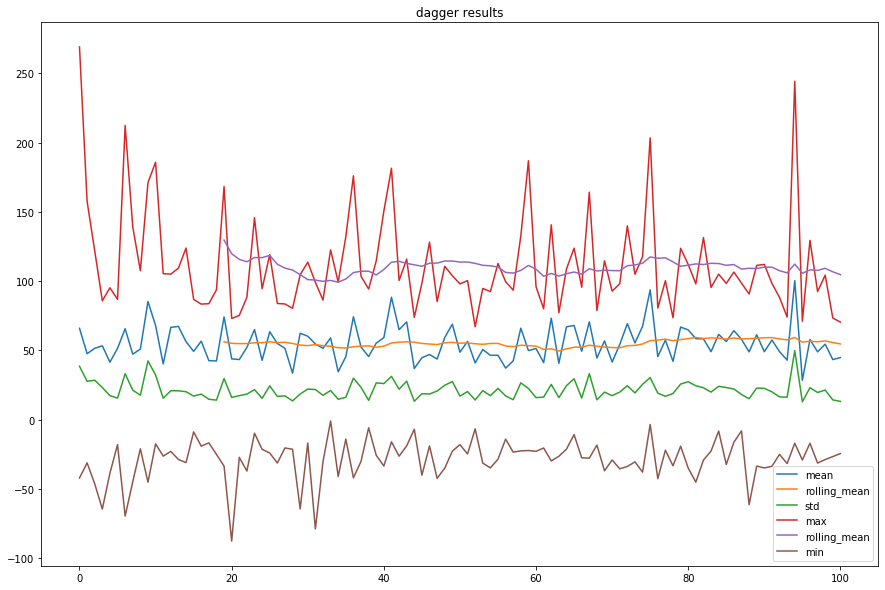

In [93]:
plt.figure(figsize=(15,10))
plt.title('dagger results')
plt.plot(dagger_rollout_results['mean'],label='mean')
plt.plot(dagger_rollout_results.rolling(20).mean()['mean'], label='rolling_mean')
plt.plot(dagger_rollout_results['std'],label='std')
plt.plot(dagger_rollout_results['max'],label='max')
plt.plot(dagger_rollout_results.rolling(20).mean()['max'], label='rolling_mean')
plt.plot(dagger_rollout_results['min'],label='min')
plt.legend()